# Лабораторная работа №6 (вариант №4)

**Цель работы** – написать программу на языке Python, выполняющую построение и обучение модели прогнозирования будущих значений на основе данных временной последовательности (выборка получена от преподавателя), требуется подобрать архитектуру рекуррентной нейронной сети, работающей с допустимым уровнем ошибки и визуализировать процесс обучения моделей и привести метрики качества. Результаты работы привести в отчете.

##Задание

В рамках данной лабораторной работы предполагается создание модели простой
рекуррентной нейронной сети для предсказания погоды.

Набор данных доступен по
ссылке: https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data.

##Импорт библиотек

In [59]:
import numpy as np
import pandas as pd

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
import missingno as msno

In [62]:
import tensorflow as tf
from tensorflow import keras

In [63]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
from sklearn.preprocessing import LabelEncoder

In [66]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [67]:
!pip install tensorflow-addons

In [68]:
from tensorflow_addons.metrics import RSquare

In [69]:
from google.colab import files
from google.colab import drive

In [70]:
# подключение диска

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
path = "/content/drive/MyDrive/STUDY/магистратура курс 2/Нейронные сети/Lab_6/"

## Функции

In [72]:
# визуализация предсказаний

def plot_predictions(model, X_test, y_test, colors):

  actual = y_test
  predictions = model.predict(X_test)
  rows = len(actual)
  plt.figure(figsize=(15, 6),dpi=100)
  plt.plot(range(rows), actual, linewidth=0.6, color = colors[0])
  plt.plot(range(rows), predictions, linewidth=0.5, color = colors[len(colors) - 1])
  plt.legend(['Реальные данные', 'Предсказания'])
  plt.xlabel('Номер наблюдения')
  plt.ylabel('Масштабированные данные')
  plt.title('Реальные и предсказанные показатели')

In [73]:
# визуализация процесса обучения

def history_visualization(history, colors):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [74]:
# вывод метрик MSE, MAE, R2

def print_metrics(model, X_test, y_test):

  predictions = model.predict(X_test)
  mse = mean_squared_error(y_test, predictions)
  mae = mean_absolute_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  print('Mean squared error from neural network: ', mse)
  print('Mean absolute error from neural network: ', mae)
  print('R2 score from neural network: ', r2)

In [75]:
# параметры графиков

palette = 'coolwarm'

colors = sns.color_palette(palette).as_hex()[:]

##Пример программы

###Считывание и просмотр набора данных

https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data

In [76]:
df = pd.read_csv(path + 'temperature.csv')
df.head()

datetime   Vancouver    Portland  San Francisco     Seattle  \
0  2012-10-01 12:00:00         NaN         NaN            NaN         NaN   
1  2012-10-01 13:00:00  284.630000  282.080000     289.480000  281.800000   
2  2012-10-01 14:00:00  284.629041  282.083252     289.474993  281.797217   
3  2012-10-01 15:00:00  284.626998  282.091866     289.460618  281.789833   
4  2012-10-01 16:00:00  284.624955  282.100481     289.446243  281.782449   

   Los Angeles   San Diego   Las Vegas     Phoenix  Albuquerque  ...  \
0          NaN         NaN         NaN         NaN          NaN  ...   
1   291.870000  291.530000  293.410000  296.600000   285.120000  ...   
2   291.868186  291.533501  293.403141  296.608509   285.154558  ...   
3   291.862844  291.543355  293.392177  296.631487   285.233952  ...   
4   291.857503  291.553209  293.381213  296.654466   285.313345  ...   

   Philadelphia    New York    Montreal      Boston   Beersheba  \
0           NaN         NaN         NaN         NaN         NaN   
1    285.630000  288.220000  285.830000  287.170000  307.590000   
2    285.663208  288.247676  285.834650  287.186092  307.590000   
3    285.756824  288.326940  285.847790  287.231672  307.391513   
4    285.850440  288.406203  285.860929  287.277251  307.145200   

   Tel Aviv District       Eilat  Haifa  Nahariyya  Jerusalem  
0                NaN  309.100000    NaN        NaN        NaN  
1         305.470000  310.580000  304.4      304.4      303.5  
2         304.310000  310.495769  304.4      304.4      303.5  
3         304.281841  310.411538  304.4      304.4      303.5  
4         304.238015  310.327308  304.4      304.4      303.5  

[5 rows x 37 columns]

Список городов:

In [77]:
print(df.columns)

Index(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa',
       'Nahariyya', 'Jerusalem'],
      dtype='object')


Выбор города для предсказания погоды.

In [78]:
df = df[['datetime', 'Jerusalem']]

###Подготовка данных

####Пропущенные значения

Проверка, что данный набор данных не содержит пропущенных значений. Удаление строк
с пропущенными значениями.

In [79]:
df.isna().sum()
df = df.dropna()

####Масштабирование данных

Выполните масштабирование данных. Все значения должны быть отмасштабированы от 0
до 1.

In [80]:
data = df['Jerusalem'].values
scaler = MinMaxScaler(feature_range=(0, 1))
data = data.reshape(-1, 1)
data = scaler.fit_transform(data).flatten()

####Сглаживание данных

Выполним сглаживание данных для уменьшения отдельных значений содержащие
статистические аномалии: для уменьшения влияния отдельных необычно больших или
малых значений на результат вычисления.
Выполним обработку скользящим окном размера 20.

In [81]:
def get_XY(data, window):
  Y_index = np.arange(window, len(data), window)
  Y = data[Y_index]
  rows_x = len(Y)
  X = data[range(window*rows_x)]
  X = np.reshape(X, (rows_x, window, 1))
  return X, Y

window = 20
X, y = get_XY(data, window)

In [82]:
print(X.shape)

(2222, 20, 1)


In [83]:
print(y.shape)

(2222,)


####Разделение на выборки

Разбиение всей выборки на обучающую и тестовую, на обучающей выборке будет обучаться
модель, на тестовой будет проводится оценка.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size = 0.2,
random_state = 0)

###Модель нейронной сети

Создайте полносвязную модель рекуррентной нейронной сети с одним скрытым слоем.
Выходной слой возвращает одно число - температуру. В качестве функции потерь
используется средняя абсолютная ошибка (mae), оптимизатор — adam, во время обучения
будем отслеживать метрики mse и среднюю абсолютную ошибку (mae).

In [85]:
def create_RNN(hidden_units, dense_units, input_shape, activation):

  model = Sequential()

  model.add(
      SimpleRNN(
              hidden_units,
              input_shape=input_shape,
              activation=activation[0],
              return_sequences=False
            )
        )

  model.add(
      Dense(
          units=dense_units,
          activation=activation[1]
        )
      )

  model.compile(
      loss='mean_squared_error',
      optimizer='adam',
      metrics=[
        'mean_absolute_error',
        'mean_squared_error'
      ]
    )

  model.summary()

  return model

In [86]:
model = create_RNN(
    hidden_units=32,
    dense_units=1,
    input_shape=(window,1),
    activation=['relu', 'linear']
  )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###Обучение модели

Выполним обучение модели на 20 эпохах, 20 процентов обучающей выборки будет
использовано для оценки модели, во время обучения, размер пакета 32.

In [87]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    verbose=1,
    validation_split=0.2
  )

Epoch 1/20
45/45 [==============================] - 2s 17ms/step - loss: 0.1789 - mean_absolute_error: 0.3073 - mean_squared_error: 0.1789 - val_loss: 0.0138 - val_mean_absolute_error: 0.1019 - val_mean_squared_error: 0.0138
Epoch 2/20
45/45 [==============================] - 0s 10ms/step - loss: 0.0079 - mean_absolute_error: 0.0730 - mean_squared_error: 0.0079 - val_loss: 0.0048 - val_mean_absolute_error: 0.0582 - val_mean_squared_error: 0.0048
Epoch 3/20
45/45 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_absolute_error: 0.0510 - mean_squared_error: 0.0041 - val_loss: 0.0032 - val_mean_absolute_error: 0.0443 - val_mean_squared_error: 0.0032
Epoch 4/20
45/45 [==============================] - 1s 21ms/step - loss: 0.0030 - mean_absolute_error: 0.0427 - mean_squared_error: 0.0030 - val_loss: 0.0025 - val_mean_absolute_error: 0.0384 - val_mean_squared_error: 0.0025
Epoch 5/20
45/45 [==============================] - 1s 17ms/step - loss: 0.0023 - mean_absolute_error

###Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

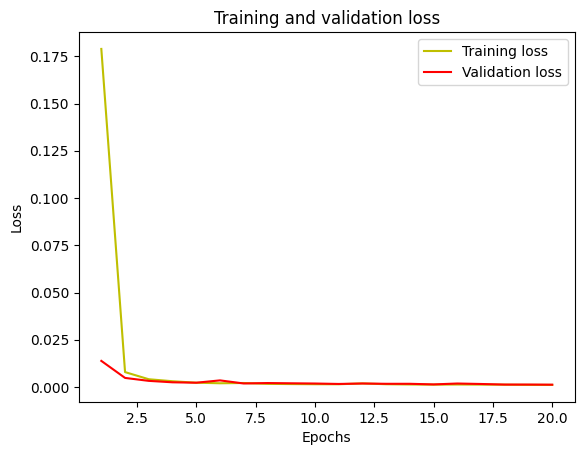

In [88]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Выполним вывод различных метрик оценки качества модели.

In [89]:
def print_error(trainY, testY, train_predict, test_predict):
  # Error of predictions
  mae = (mean_absolute_error(trainY, train_predict))
  mse = (mean_squared_error(trainY, train_predict))
  # Print RMSE
  print('train MAE: %.10f' % (mae))
  print('train MSE: %.10f' % (mse))
  # Error of predictions
  mae = (mean_absolute_error(testY, test_predict))
  mse = (mean_squared_error(testY, test_predict))
  # Print RMSE
  print('test MAE: %.10f' % (mae))
  print('test MSE: %.10f' % (mse))

# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
print_error(y_train, y_test, train_predict, test_predict)

14/14 [==============================] - 0s 6ms/step
train MAE: 0.0229289204
train MSE: 0.0010444548
test MAE: 0.0224186764
test MSE: 0.0010298513


Визуализируем предсказание модели и сравним с реальными данными.

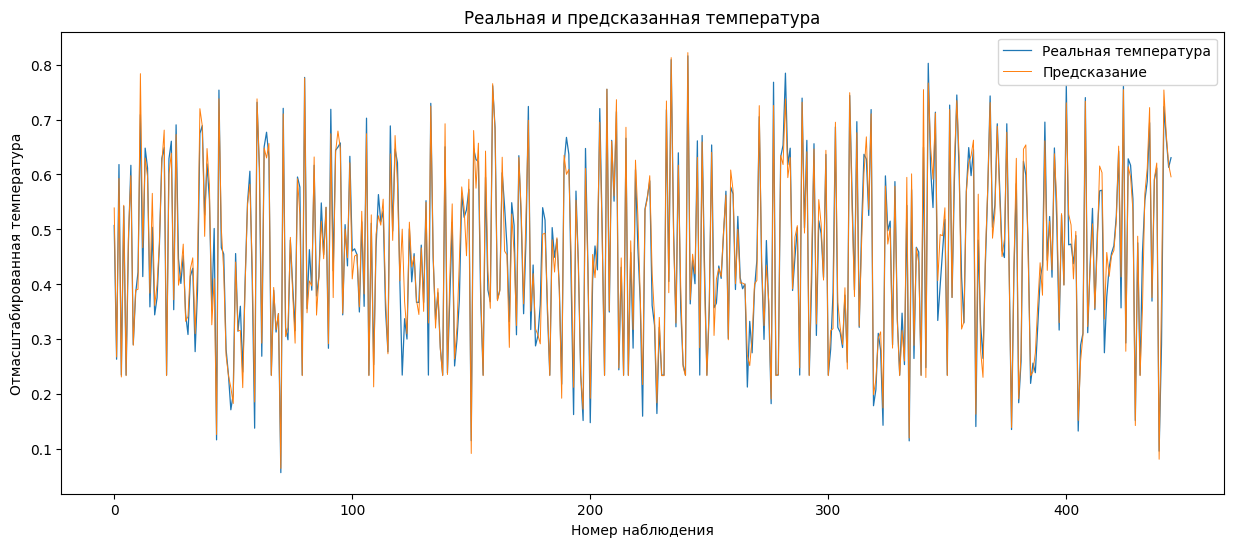

In [90]:
def plot_result(testY, test_predict):
  actual = testY
  predictions = test_predict
  rows = len(actual)
  plt.figure(figsize=(15, 6),dpi=100)
  plt.plot(range(rows), actual, linewidth=0.9)
  plt.plot(range(rows), predictions, linewidth=0.7)
  plt.legend(['Реальная температура', 'Предсказание'])
  plt.xlabel('Номер наблюдения')
  plt.ylabel('Отмасштабированная температура')
  plt.title('Реальная и предсказанная температура')

plot_result(y_test, test_predict)

##Задание по вариантам

Исследование рекуррентной нейросети (прогноз температуры).

Написать программу на Python, которая обучает регрессионные модели, предсказывающие температуру на завтрашний день в одном из городов и построенных на наборе данных с помощью трёх алгоритмов:

* простая рекуррентная нейронная сеть,
* LSTM (или GRU),
* стек LSTM (или стек GRU).

Датасет – Выборка погода Якутск.

Исследование рекуррентной нейросети (прогноз температуры).

Написать программу на Python, которая обучает регрессионные модели, предсказывающие температуру на завтрашний день в одном из городов и построенных на наборе данных с помощью трёх алгоритмов:

* простая рекуррентная нейронная сеть,
* LSTM (или GRU),
* стек LSTM (или стек GRU).

Датасет – Выборка погода Якутск.

Данные были скачаны с сайта https://rp5.ru со страницы архива погоды в Якутске:

https://rp5.ru/%D0%90%D1%80%D1%85%D0%B8%D0%B2_%D0%BF%D0%BE%D0%B3%D0%BE%D0%B4%D1%8B_%D0%B2_%D0%AF%D0%BA%D1%83%D1%82%D1%81%D0%BA%D0%B5



Набор данных содержит следующие признаки:

* T - температура в градусах Цельсия на расстоянии 2-х метров от поверхности земли.
* P0 - атмосферное давление в мм. ртутного столба на уровне станции.
* P - атмосферное давление в мм. ртутного столба, приведенное к среднему на уровне моря.
* U - относительная влажность в процентах на уровне 2-х метров от поверхности земли.
* DD - направление ветра на высоте 10-12 метров над поверхностью.

###Считывание и подготовка набора данных

С помощью библиотеки chardet узнаем кодировку файла и считываем данные во фрейм.

In [91]:
import chardet

with open(path + 'Yakutsk_weather.csv', 'rb') as f:
    result = chardet.detect(f.read())

In [92]:
df = pd.read_csv(path + 'Yakutsk_weather.csv', encoding=result['encoding'], engine='python', sep=';')
df

LocalTime    T     P0      P     U     DD
0       19.10.2020 17:00 -7.0  745.9  758.2  68.0  Ветер
1       19.10.2020 16:30 -6.0  746.0  758.2  63.0  Ветер
2       19.10.2020 16:00 -5.0  746.0  758.2  58.0  Ветер
3       19.10.2020 15:30 -4.0  746.1  758.2  59.0  Ветер
4       19.10.2020 15:00 -4.0  746.1  758.2  54.0  Ветер
...                  ...  ...    ...    ...   ...    ...
116046  01.10.2012 04:00  2.0  742.8  754.6  87.0  Ветер
116047  01.10.2012 03:00  2.0  743.6  755.4  87.0  Ветер
116048  01.10.2012 02:00  2.0  743.6  755.4  87.0  Ветер
116049  01.10.2012 01:00  2.0  744.4  756.2  87.0  Ветер
116050  01.10.2012 00:00  2.0  744.4  756.2  87.0  Ветер

[116051 rows x 6 columns]

####Обработка пропущенных значений

Используя библиотеку missingno выясняем, есть ли пропущенные значения в датасете. Как видно из графика ниже, в данных есть небольшое количество пропусков.

<Axes: >

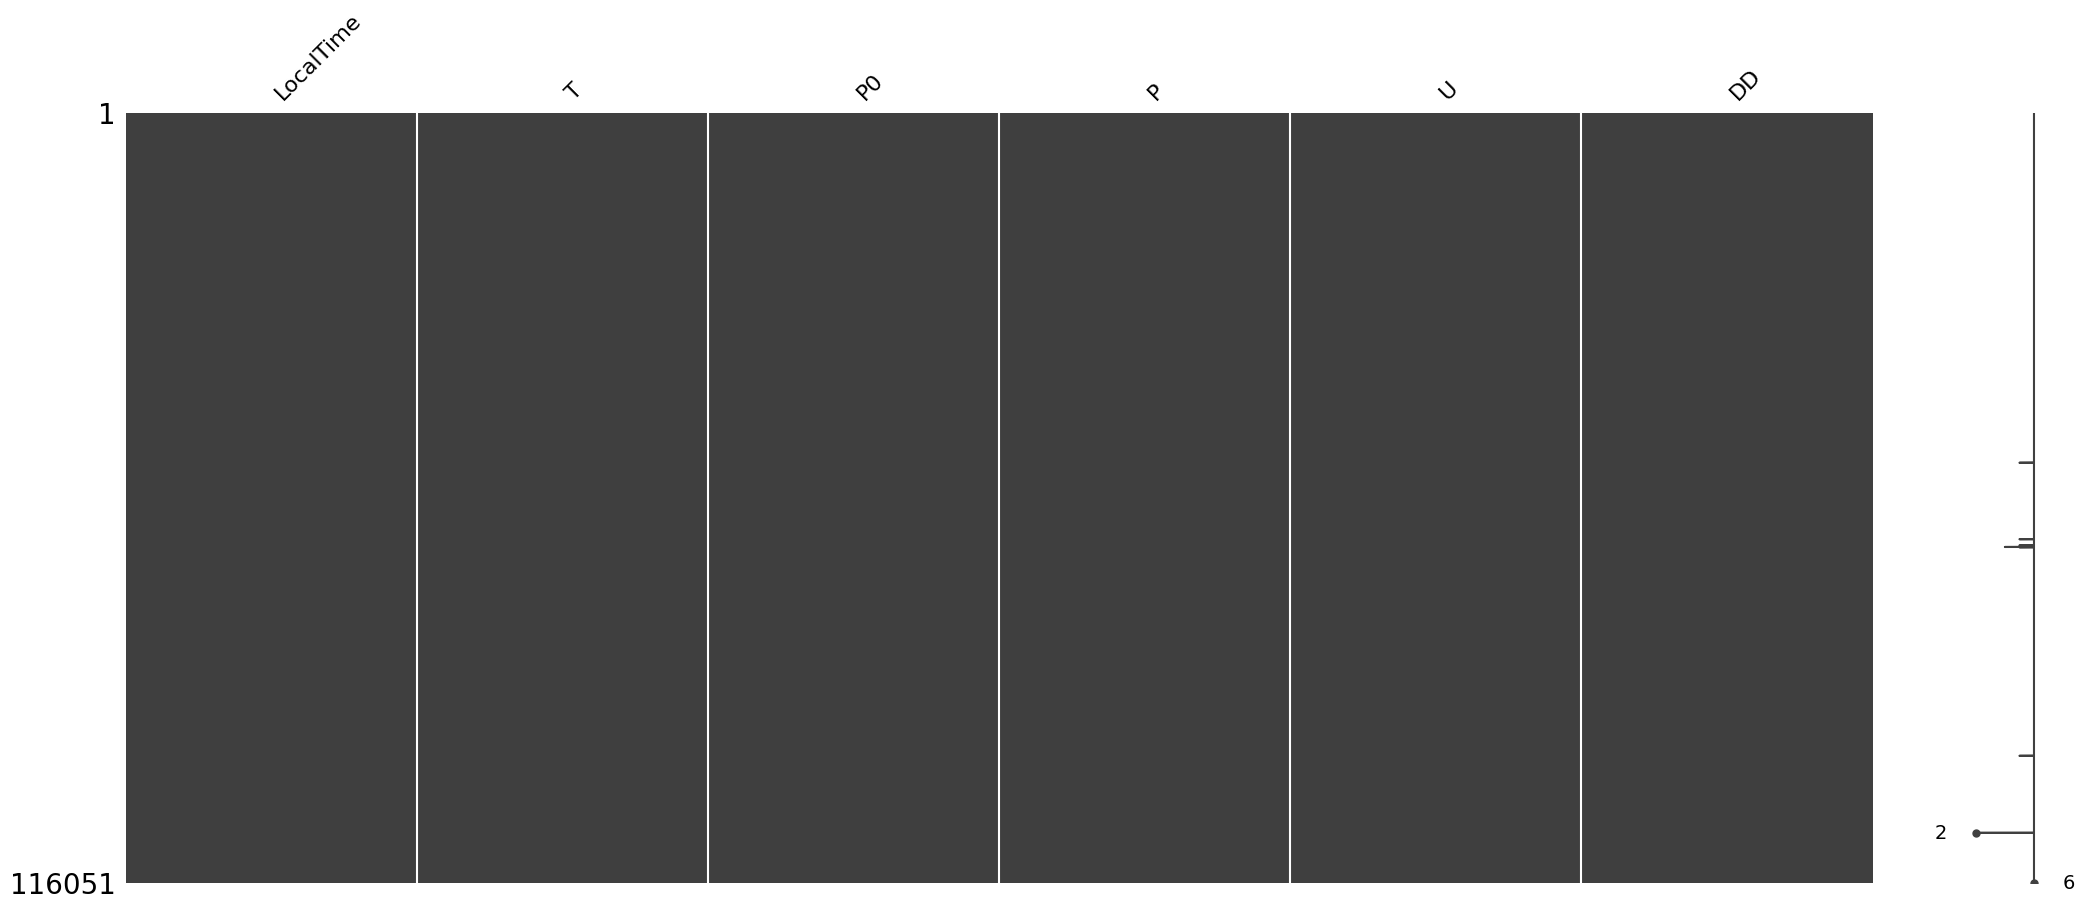

In [93]:
msno.matrix(df)

In [94]:
df.isna().sum()

LocalTime    0
T            1
P0           2
P            2
U            3
DD           3
dtype: int64

Так как пропусков немного, их можно просто удалить.

In [95]:
df = df.dropna()
df.isna().sum()

LocalTime    0
T            0
P0           0
P            0
U            0
DD           0
dtype: int64

####Кодирование категориальных переменных

Выведем информацию о датасете.

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116044 entries, 0 to 116050
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   LocalTime  116044 non-null  object 
 1   T          116044 non-null  float64
 2   P0         116044 non-null  float64
 3   P          116044 non-null  float64
 4   U          116044 non-null  float64
 5   DD         116044 non-null  object 
dtypes: float64(4), object(2)
memory usage: 6.2+ MB


В датасете есть признаки типа object. Закодируем категориальные переменные с помощью LabelEncoder.

In [97]:
df_enc = df.copy()

In [98]:
# Кодирование категориальных факторов

encoder = LabelEncoder()

for i in df_enc:
    if df_enc[i].dtypes == 'object':
       df_enc[i] = encoder.fit_transform(df_enc[i])
df_enc

LocalTime    T     P0      P     U  DD
0           72172 -7.0  745.9  758.2  68.0   0
1           72171 -6.0  746.0  758.2  63.0   0
2           72170 -5.0  746.0  758.2  58.0   0
3           72169 -4.0  746.1  758.2  59.0   0
4           72168 -4.0  746.1  758.2  54.0   0
...           ...  ...    ...    ...   ...  ..
116046       2805  2.0  742.8  754.6  87.0   0
116047       2804  2.0  743.6  755.4  87.0   0
116048       2803  2.0  743.6  755.4  87.0   0
116049       2802  2.0  744.4  756.2  87.0   0
116050       2801  2.0  744.4  756.2  87.0   0

[116044 rows x 6 columns]

####Отбор признаков

Построим графики для всех признаков.

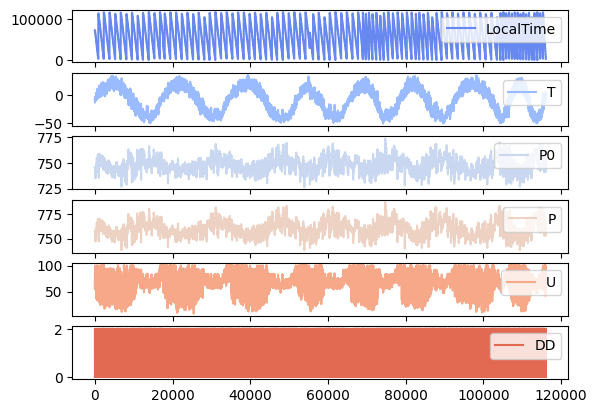

In [99]:
df_enc.plot(subplots=True, legend=False, color = colors)

for ax in plt.gcf().axes:
    ax.legend(loc=1)

Как мы видим, признак DD (направление ветра) не обладает такой периодичностью, как остальные признаки, поэтому его можно исключить из рассмотрения. LocalTime исключается тоже, так как не обладает нужной информативностью.

Создадим датасет рассматриваемых признаков.

In [100]:
# список названий рассматриваемых признаков

features_considered = ['T', 'P0', 'P', 'U']

In [101]:
# количество рассматриваемых признаков

features_num = len(features_considered)

In [102]:
# признаки

features = df_enc[features_considered]

In [103]:
# устанавливаем дату и время в качестве индекса

features.index = df['LocalTime']

In [104]:
features.head()

T     P0      P     U
LocalTime                                
19.10.2020 17:00 -7.0  745.9  758.2  68.0
19.10.2020 16:30 -6.0  746.0  758.2  63.0
19.10.2020 16:00 -5.0  746.0  758.2  58.0
19.10.2020 15:30 -4.0  746.1  758.2  59.0
19.10.2020 15:00 -4.0  746.1  758.2  54.0

####Масштабирование данных

Выполним масштабирование данных в диапазон от 0
до 1.

In [105]:
data = features.copy()

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

####Сглаживание данных

Сглаживание данных представляет собой процесс уменьшения шума и выбросов в наборе данных. Чаще всего используется в случаях, когда данные имеют большие колебания или нерегулярности. В нейронных сетях сглаживание данных может помочь снизить эффект переобучения и улучшить общую производительность сети.

Одной из наиболее распространенных техник сглаживания данных является применение метода скользящего среднего. Этот метод заключается в вычислении среднего значения по подмножеству набора данных, а затем замене всех значений этим средним значением. Таким образом, изначально колеблющиеся значения сглаживаются, что позволяет увидеть общую тенденцию данных. Это поможет устранить выбросы и шум в выходных значениях слоя, что повысит точность прогнозирования и обучение сети, так как в результате полученные данные будут более регулярными и лучше соответствовать общей тенденции, что позволит нейронной сети более эффективно обучаться и делать точные прогнозы.

In [106]:
def smooth_data(data, sm_columns, window_size = 20):

  if (sm_columns == []):
    return data

  smoothed_data = np.zeros_like(data)

  for i in range(0, data.shape[0]):

    for j in range(0, data.shape[1]):

      if j in sm_columns:
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
        smoothed_data[i,j] = np.mean(data[:, j][start:end])

      else:
        smoothed_data[:,j] = data[:, j]

  return smoothed_data

In [107]:
#sm_cols = ['T', 'P0', 'P', 'U']
sm_cols = []

In [108]:
sm_cols_idx = []

for colname in sm_cols:
  sm_cols_idx.append(sm_cols.index(colname))
  #print(features_considered.index(colname))

In [109]:
# последний столбец - ветер - не сглаживаем
window_size = 20
sm_data = smooth_data(data, sm_cols_idx, window_size)

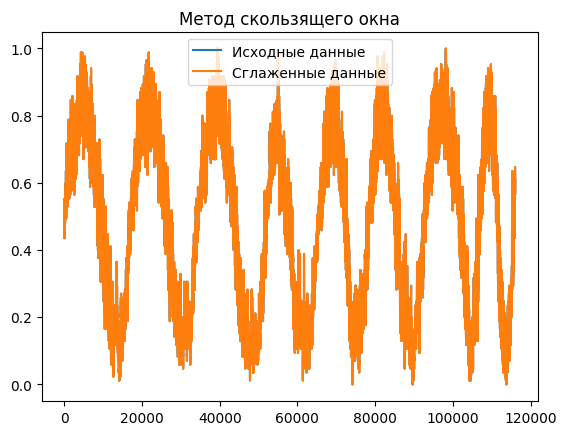

In [110]:
plt.plot(data[:,0], label='Исходные данные')
plt.plot(sm_data[:, 0], label='Сглаженные данные')
plt.title('Метод скользящего окна')
plt.legend()
plt.show()

####Сериализация данных

Приведенная ниже функция возвращает временные интервалы для обучения модели. Аригумент series_size - это количество предыдущих значений, используемых для прогноза.

In [112]:
def create_time_series(data, series_size):
  Y_index = np.arange(series_size, len(data), series_size)
  Y = data[:, 0][Y_index]
  Y = np.reshape(Y, (-1, 1))

  rows_x = len(Y)

  X = np.zeros_like(data[:, :])

  X = data[:, :][range(series_size*rows_x)]
  X = np.reshape(X, (rows_x, series_size, -1))

  return X, Y

In [113]:
series_size = 20

X, y = create_time_series(sm_data, series_size)

####Разделение на выборки

Разбиение выборки на обучающую и тестовую, на обучающей выборке будет обучаться
модель, на тестовой будет проводится оценка.

In [114]:
# выборки для обучения

X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  train_size=0.7,
  random_state=0
)

In [115]:
# выборки для тестирования и валидации

X_test, X_val, y_test, y_val = train_test_split(
  X_test,
  y_test,
  train_size=0.5,
  random_state=0
)

###Simple RNN

SimpleRNN в Keras - это реализация простой рекуррентной нейронной сети (RNN) в библиотеке Keras. RNN является одним из типов нейронных сетей, которые поддерживают обработку последовательных данных, таких как временные ряды или естественные языки.

SimpleRNN имеет один скрытый слой, который рекурсивно передает информацию из предыдущего временного шага в следующий. Это связано с возможностью моделирования долгосрочных зависимостей в данных. SimpleRNN может быть использован для задач классификации, регрессии или генерации последовательностей.

####Модель №1

Создаем полносвязную модель рекуррентной нейронной сети с одним скрытым слоем.
Выходной слой возвращает одно число - температуру. В качестве функции потерь
используется средняя абсолютная ошибка (mae), оптимизатор — adam, во время обучения
будем отслеживать метрики mse, среднюю абсолютную ошибку (mae) и коэффициент детерминации R^2.

Слой RNN содержит 32 нейрона, функция активации - relu. Параметр return_sequences означает, следует ли возвращать последний вывод в выходной последовательности или полную последовательность, в данном случае он установлен в False, то есть слой RNN возвращает только последний вывод. Размеры входного вектора (input_shape) - (количество наблюдений в серии, количество признаков).

Слой Dense содержит 1 нейрон, функция активации - линейная.

В качестве функции потерь используем MSE, используемые метрики - MAE, MSE, R2. Оптимизатор - adam.

Модель будет обучена на 20 эпохах с размером батча, равным 32.





In [116]:
# ассоциативный массив параметров архитектуры модели
# и обучения модели

Params = dict()

rnn_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

rnn_params['units'] = 32
rnn_params['input_shape'] = (series_size,features_num)
rnn_params['activation'] = ['relu']
rnn_params['is_sequences'] = [False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 20
train_params['batch_size'] = 32



Params['rnn_params'] = rnn_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [117]:
Params

{'rnn_params': {'units': 32,
  'input_shape': (20, 4),
  'activation': ['relu'],
  'is_sequences': [False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7a20c9225300>]},
 'train_params': {'epochs': 20, 'batch_size': 32}}

In [118]:
rnn_model_1 = Sequential()

rnn_model_1.add(
    SimpleRNN(
            Params['rnn_params']['units'],
            input_shape = Params['rnn_params']['input_shape'],
            activation = Params['rnn_params']['activation'][0],
            return_sequences = Params['rnn_params']['is_sequences'][0]
          )
      )

rnn_model_1.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

rnn_model_1.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

rnn_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1184      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [119]:
rnn_model_1_history = rnn_model_1.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/20
127/127 [==============================] - 3s 13ms/step - loss: 0.0028 - mean_absolute_error: 0.0317 - mean_squared_error: 0.0028 - r_square: 0.9580 - val_loss: 3.8916e-04 - val_mean_absolute_error: 0.0148 - val_mean_squared_error: 3.8916e-04 - val_r_square: 0.9939
Epoch 2/20
127/127 [==============================] - 1s 7ms/step - loss: 3.4122e-04 - mean_absolute_error: 0.0139 - mean_squared_error: 3.4122e-04 - r_square: 0.9948 - val_loss: 3.1938e-04 - val_mean_absolute_error: 0.0139 - val_mean_squared_error: 3.1938e-04 - val_r_square: 0.9950
Epoch 3/20
127/127 [==============================] - 1s 6ms/step - loss: 2.8148e-04 - mean_absolute_error: 0.0127 - mean_squared_error: 2.8148e-04 - r_square: 0.9957 - val_loss: 2.4557e-04 - val_mean_absolute_error: 0.0119 - val_mean_squared_error: 2.4557e-04 - val_r_square: 0.9962
Epoch 4/20
127/127 [==============================] - 1s 6ms/step - loss: 2.5906e-04 - mean_absolute_error: 0.0121 - mean_squared_error: 2.5906e-04 - r_squ

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-73-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-73-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


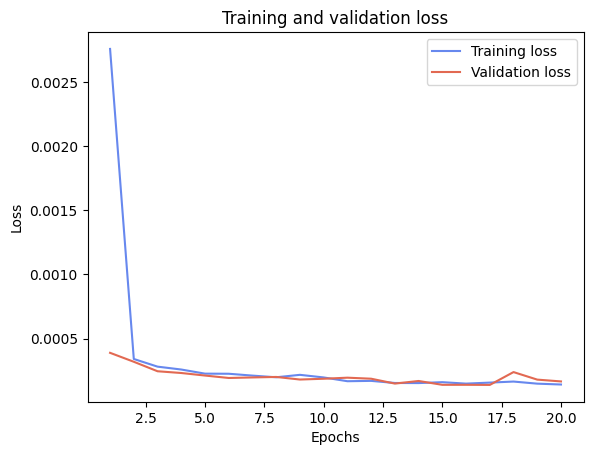

In [120]:
history_visualization(rnn_model_1_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [121]:
print_metrics(rnn_model_1, X_test, y_test)

28/28 [==============================] - 0s 2ms/step
Mean squared error from neural network:  0.00015663831605866347
Mean absolute error from neural network:  0.009459407219708608
R2 score from neural network:  0.99753851301171


Визуализируем предсказание модели и сравним с реальными данными.

28/28 [==============================] - 0s 2ms/step


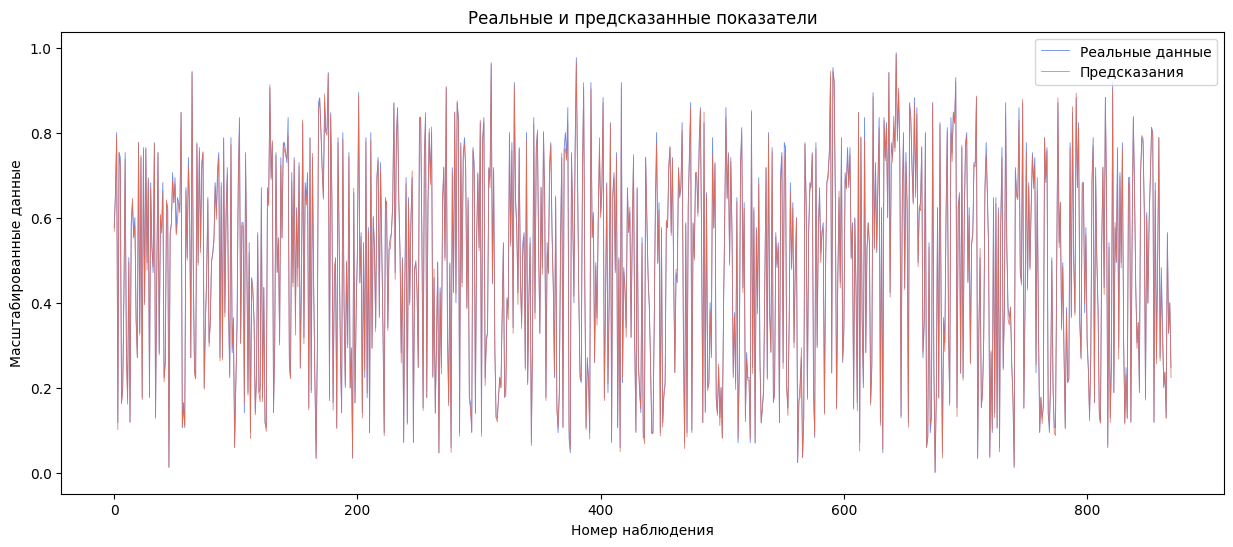

In [122]:
plot_predictions(rnn_model_1, X_test, y_test, colors)

Как видно из последнего графика, предсказанные значения практически совпадают с реальными данными.

####Модель №2

Попробуем изменить оптимизатор на RMSprop и уменьшить размер батча до 8. Увеличим количество эпох до 30. Другие параметры остаются прежними.

In [123]:
Params = dict()

rnn_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

rnn_params['units'] = 32
rnn_params['input_shape'] = (series_size,features_num)
rnn_params['activation'] = ['relu']
rnn_params['is_sequences'] = [False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'RMSprop'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 30
train_params['batch_size'] = 8



Params['rnn_params'] = rnn_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [124]:
Params

{'rnn_params': {'units': 32,
  'input_shape': (20, 4),
  'activation': ['relu'],
  'is_sequences': [False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'RMSprop',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7a20c97722c0>]},
 'train_params': {'epochs': 30, 'batch_size': 8}}

In [125]:
rnn_model_2 = Sequential()

rnn_model_2.add(
    SimpleRNN(
            Params['rnn_params']['units'],
            input_shape = Params['rnn_params']['input_shape'],
            activation = Params['rnn_params']['activation'][0],
            return_sequences = Params['rnn_params']['is_sequences'][0]
          )
      )

rnn_model_2.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

rnn_model_2.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

rnn_model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1184      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [126]:
rnn_model_2_history = rnn_model_2.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/30
508/508 [==============================] - 4s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0347 - mean_squared_error: 0.0040 - r_square: 0.9384 - val_loss: 3.5608e-04 - val_mean_absolute_error: 0.0150 - val_mean_squared_error: 3.5608e-04 - val_r_square: 0.9944
Epoch 2/30
508/508 [==============================] - 3s 6ms/step - loss: 6.2644e-04 - mean_absolute_error: 0.0202 - mean_squared_error: 6.2644e-04 - r_square: 0.9904 - val_loss: 2.2554e-04 - val_mean_absolute_error: 0.0118 - val_mean_squared_error: 2.2554e-04 - val_r_square: 0.9965
Epoch 3/30
508/508 [==============================] - 4s 8ms/step - loss: 4.4557e-04 - mean_absolute_error: 0.0166 - mean_squared_error: 4.4557e-04 - r_square: 0.9932 - val_loss: 9.2290e-04 - val_mean_absolute_error: 0.0277 - val_mean_squared_error: 9.2290e-04 - val_r_square: 0.9856
Epoch 4/30
508/508 [==============================] - 4s 7ms/step - loss: 3.5899e-04 - mean_absolute_error: 0.0151 - mean_squared_error: 3.5899e-04 - r_squa

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-73-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-73-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


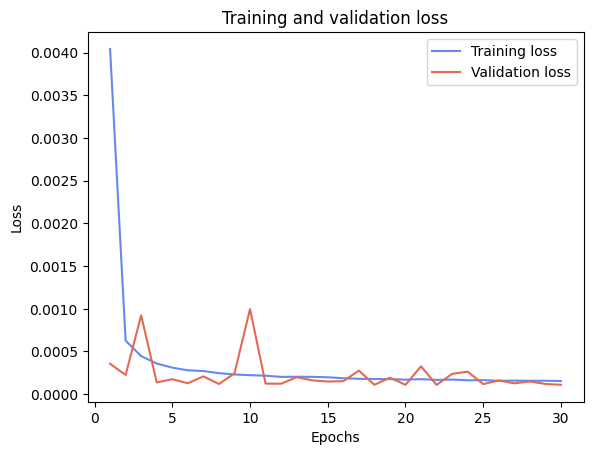

In [127]:
history_visualization(rnn_model_2_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [128]:
print_metrics(rnn_model_2, X_test, y_test)

28/28 [==============================] - 0s 5ms/step
Mean squared error from neural network:  9.763437133084795e-05
Mean absolute error from neural network:  0.0073484607873090255
R2 score from neural network:  0.9984657283052587


Визуализируем предсказание модели и сравним с реальными данными.

28/28 [==============================] - 0s 3ms/step


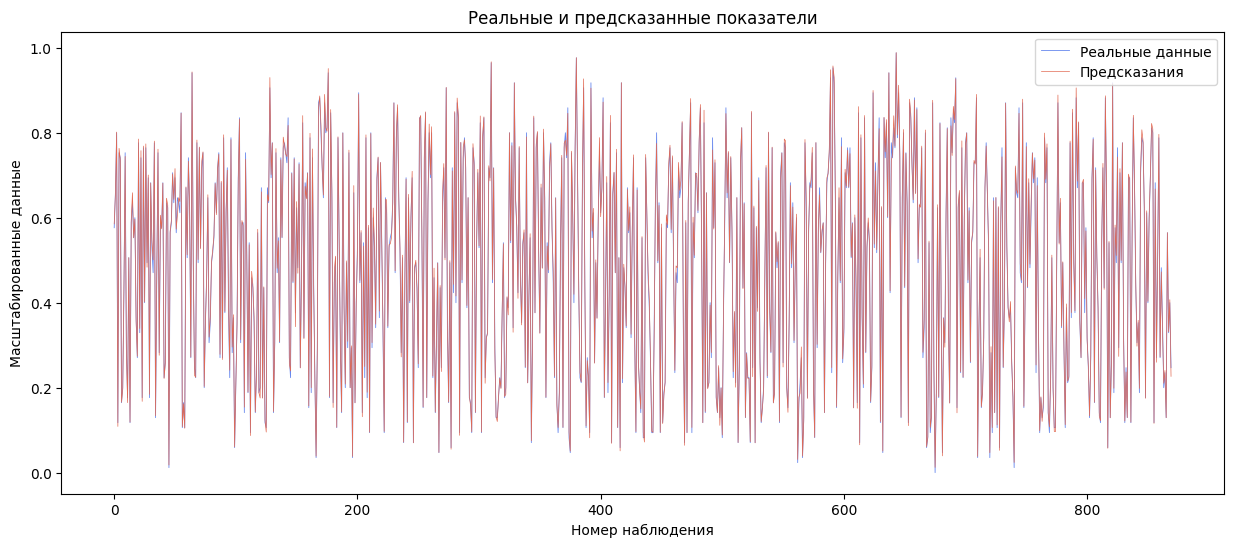

In [129]:
plot_predictions(rnn_model_2, X_test, y_test, colors)

Как видим, обучение модели с оптимизатором RMSprop щло не так гладко, как с adam, но, тем не менее, с выбранными параметрами модель обучилась достаточно хорошо и предсказывает с высокой точностью.

####Модель №3

Оставим в качестве оптимизатора adam, потому что с ним кривая потерь более гладкая. Увеличим количество нейронов в RNN до 64, вернем прежний размер батча - 32 и будем обучать модель в течение 30 эпох.

In [130]:
Params = dict()

rnn_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

rnn_params['units'] = 64
rnn_params['input_shape'] = (series_size,features_num)
rnn_params['activation'] = ['relu']
rnn_params['is_sequences'] = [False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 30
train_params['batch_size'] = 32



Params['rnn_params'] = rnn_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [131]:
Params

{'rnn_params': {'units': 64,
  'input_shape': (20, 4),
  'activation': ['relu'],
  'is_sequences': [False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7a20c9926c20>]},
 'train_params': {'epochs': 30, 'batch_size': 32}}

In [132]:
rnn_model_3 = Sequential()

rnn_model_3.add(
    SimpleRNN(
            Params['rnn_params']['units'],
            input_shape = Params['rnn_params']['input_shape'],
            activation = Params['rnn_params']['activation'][0],
            return_sequences = Params['rnn_params']['is_sequences'][0]
          )
      )

rnn_model_3.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

rnn_model_3.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

rnn_model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 64)                4416      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [133]:
rnn_model_3_history = rnn_model_3.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/30
127/127 [==============================] - 3s 13ms/step - loss: 0.0318 - mean_absolute_error: 0.0912 - mean_squared_error: 0.0318 - r_square: 0.5147 - val_loss: 4.8875e-04 - val_mean_absolute_error: 0.0172 - val_mean_squared_error: 4.8875e-04 - val_r_square: 0.9924
Epoch 2/30
127/127 [==============================] - 1s 8ms/step - loss: 3.7463e-04 - mean_absolute_error: 0.0147 - mean_squared_error: 3.7463e-04 - r_square: 0.9943 - val_loss: 3.0582e-04 - val_mean_absolute_error: 0.0132 - val_mean_squared_error: 3.0582e-04 - val_r_square: 0.9952
Epoch 3/30
127/127 [==============================] - 1s 6ms/step - loss: 3.0335e-04 - mean_absolute_error: 0.0130 - mean_squared_error: 3.0335e-04 - r_square: 0.9954 - val_loss: 2.6580e-04 - val_mean_absolute_error: 0.0120 - val_mean_squared_error: 2.6580e-04 - val_r_square: 0.9959
Epoch 4/30
127/127 [==============================] - 1s 5ms/step - loss: 2.7341e-04 - mean_absolute_error: 0.0122 - mean_squared_error: 2.7341e-04 - r_squ

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-73-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-73-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


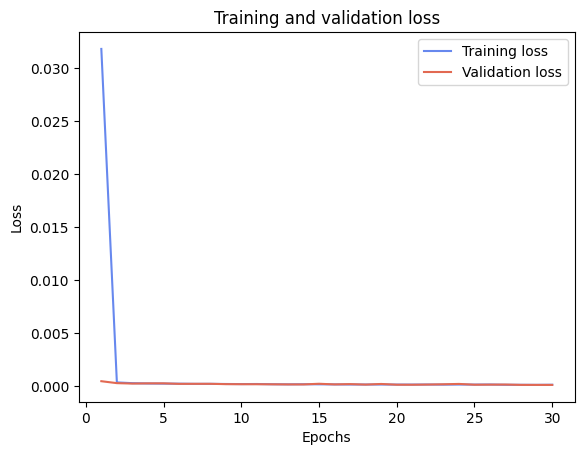

In [134]:
history_visualization(rnn_model_3_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [135]:
print_metrics(rnn_model_3, X_test, y_test)

28/28 [==============================] - 0s 2ms/step
Mean squared error from neural network:  0.00013289040214188797
Mean absolute error from neural network:  0.008475118564332243
R2 score from neural network:  0.9979116987211586


Визуализируем предсказание модели и сравним с реальными данными.

28/28 [==============================] - 0s 3ms/step


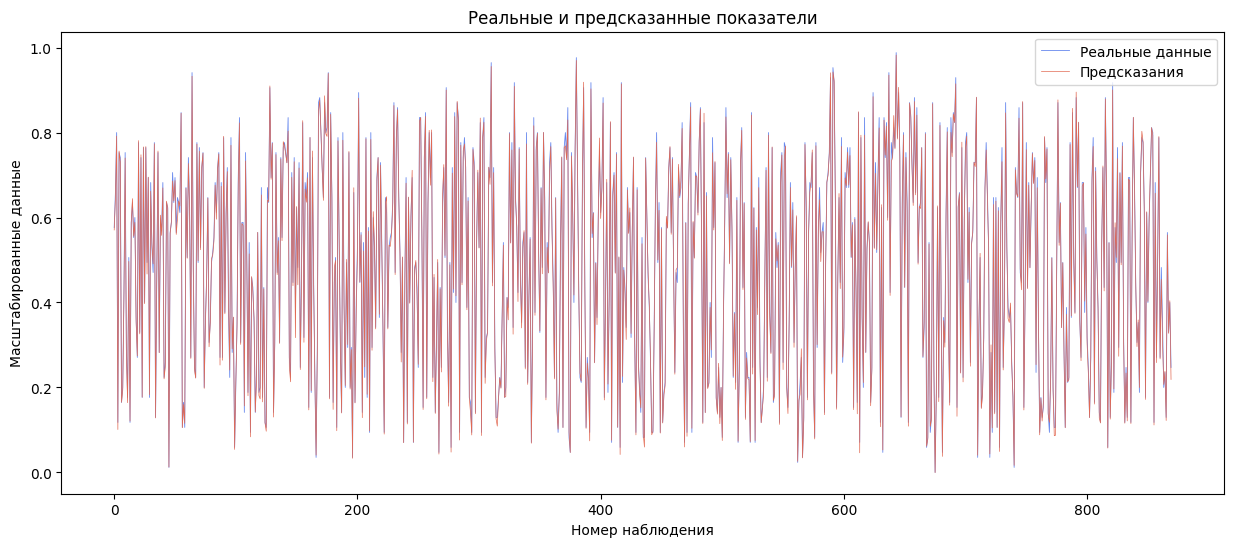

In [136]:
plot_predictions(rnn_model_3, X_test, y_test, colors)

Увеличение количества нейронов не привело к обучению. Процесс обучения модели шел гладко и, как видно по графикам, предсказанные значения практически совпадают с реальными.

####Модель №4

Проведем эксперименты со слоем Dropout. Добавим в RNN-слой параметр dropout, равный 0.1. Количество эпох установив равным 30 и добавим callback для ранней остановки, который остановит обучение, если в течение 5 эпох mae на валидационной выборке не уменьшится.

In [137]:
Params = dict()

rnn_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

rnn_params['units'] = 64
rnn_params['input_shape'] = (series_size,features_num)
rnn_params['activation'] = ['relu']
rnn_params['is_sequences'] = [False]
rnn_params['dropout'] = [0.1]


dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 30
train_params['batch_size'] = 32



Params['rnn_params'] = rnn_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [138]:
Params

{'rnn_params': {'units': 64,
  'input_shape': (20, 4),
  'activation': ['relu'],
  'is_sequences': [False],
  'dropout': [0.1]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7a20c82684c0>]},
 'train_params': {'epochs': 30, 'batch_size': 32}}

In [139]:
rnn_model_4 = Sequential()

rnn_model_4.add(
    SimpleRNN(
            Params['rnn_params']['units'],
            input_shape = Params['rnn_params']['input_shape'],
            activation = Params['rnn_params']['activation'][0],
            dropout = Params['rnn_params']['dropout'][0],
            return_sequences = Params['rnn_params']['is_sequences'][0]
          )
      )

rnn_model_4.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

rnn_model_4.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

rnn_model_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 64)                4416      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [140]:
early_stop = EarlyStopping(
    monitor = 'val_mae',
    patience = 5,
    mode = 'min',
    verbose = 1
  )

callbacks_list = [early_stop]

In [141]:
rnn_model_4_history = rnn_model_4.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    callbacks = callbacks_list,
    verbose = 1
  )

Epoch 1/30
122/127 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590 - mean_squared_error: 0.0068 - r_square: 0.8963

127/127 [==============================] - 3s 14ms/step - loss: 0.0066 - mean_absolute_error: 0.0581 - mean_squared_error: 0.0066 - r_square: 0.8991 - val_loss: 0.0035 - val_mean_absolute_error: 0.0487 - val_mean_squared_error: 0.0035 - val_r_square: 0.9447
Epoch 2/30
127/127 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.0354 - mean_squared_error: 0.0022 - r_square: 0.9664

127/127 [==============================] - 1s 11ms/step - loss: 0.0022 - mean_absolute_error: 0.0354 - mean_squared_error: 0.0022 - r_square: 0.9664 - val_loss: 0.0027 - val_mean_absolute_error: 0.0441 - val_mean_squared_error: 0.0027 - val_r_square: 0.9582
Epoch 3/30
121/127 [===========================>..] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0291 - mean_squared_error: 0.0015 - r_square: 0.9779

127/127 [==============================] - 1s 10ms/step - loss: 0.0014 - mean_absolute_error: 0.0289 - mean_squared_error: 0.0014 - r_square: 0.9780 - val_loss: 0.0047 - val_mean_absolute_error: 0.0615 - val_mean_squared_error: 0.0047 - val_r_square: 0.9260
Epoch 4/30
124/127 [============================>.] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0249 - mean_squared_error: 0.0011 - r_square: 0.9834

127/127 [==============================] - 1s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0250 - mean_squared_error: 0.0011 - r_square: 0.9834 - val_loss: 0.0048 - val_mean_absolute_error: 0.0647 - val_mean_squared_error: 0.0048 - val_r_square: 0.9246
Epoch 5/30
119/127 [===========================>..] - ETA: 0s - loss: 8.6830e-04 - mean_absolute_error: 0.0224 - mean_squared_error: 8.6830e-04 - r_square: 0.9868

127/127 [==============================] - 1s 10ms/step - loss: 8.7397e-04 - mean_absolute_error: 0.0225 - mean_squared_error: 8.7397e-04 - r_square: 0.9867 - val_loss: 0.0041 - val_mean_absolute_error: 0.0570 - val_mean_squared_error: 0.0041 - val_r_square: 0.9358
Epoch 6/30
121/127 [===========================>..] - ETA: 0s - loss: 7.8601e-04 - mean_absolute_error: 0.0212 - mean_squared_error: 7.8601e-04 - r_square: 0.9880

127/127 [==============================] - 1s 8ms/step - loss: 7.8610e-04 - mean_absolute_error: 0.0213 - mean_squared_error: 7.8610e-04 - r_square: 0.9880 - val_loss: 0.0057 - val_mean_absolute_error: 0.0687 - val_mean_squared_error: 0.0057 - val_r_square: 0.9110
Epoch 7/30
120/127 [===========================>..] - ETA: 0s - loss: 7.2704e-04 - mean_absolute_error: 0.0205 - mean_squared_error: 7.2704e-04 - r_square: 0.9889

127/127 [==============================] - 1s 7ms/step - loss: 7.1396e-04 - mean_absolute_error: 0.0203 - mean_squared_error: 7.1396e-04 - r_square: 0.9891 - val_loss: 0.0039 - val_mean_absolute_error: 0.0555 - val_mean_squared_error: 0.0039 - val_r_square: 0.9397
Epoch 8/30
124/127 [============================>.] - ETA: 0s - loss: 5.9827e-04 - mean_absolute_error: 0.0187 - mean_squared_error: 5.9827e-04 - r_square: 0.9909

127/127 [==============================] - 1s 7ms/step - loss: 5.9893e-04 - mean_absolute_error: 0.0187 - mean_squared_error: 5.9893e-04 - r_square: 0.9909 - val_loss: 0.0032 - val_mean_absolute_error: 0.0500 - val_mean_squared_error: 0.0032 - val_r_square: 0.9502
Epoch 9/30
123/127 [============================>.] - ETA: 0s - loss: 5.5130e-04 - mean_absolute_error: 0.0176 - mean_squared_error: 5.5130e-04 - r_square: 0.9916

127/127 [==============================] - 1s 7ms/step - loss: 5.4750e-04 - mean_absolute_error: 0.0176 - mean_squared_error: 5.4750e-04 - r_square: 0.9917 - val_loss: 0.0023 - val_mean_absolute_error: 0.0405 - val_mean_squared_error: 0.0023 - val_r_square: 0.9641
Epoch 10/30
123/127 [============================>.] - ETA: 0s - loss: 5.0183e-04 - mean_absolute_error: 0.0170 - mean_squared_error: 5.0183e-04 - r_square: 0.9924

127/127 [==============================] - 1s 7ms/step - loss: 5.0043e-04 - mean_absolute_error: 0.0170 - mean_squared_error: 5.0043e-04 - r_square: 0.9924 - val_loss: 0.0031 - val_mean_absolute_error: 0.0479 - val_mean_squared_error: 0.0031 - val_r_square: 0.9523
Epoch 11/30
120/127 [===========================>..] - ETA: 0s - loss: 4.2003e-04 - mean_absolute_error: 0.0154 - mean_squared_error: 4.2003e-04 - r_square: 0.9936

127/127 [==============================] - 1s 7ms/step - loss: 4.2794e-04 - mean_absolute_error: 0.0156 - mean_squared_error: 4.2794e-04 - r_square: 0.9935 - val_loss: 0.0019 - val_mean_absolute_error: 0.0367 - val_mean_squared_error: 0.0019 - val_r_square: 0.9696
Epoch 12/30
123/127 [============================>.] - ETA: 0s - loss: 4.4442e-04 - mean_absolute_error: 0.0161 - mean_squared_error: 4.4442e-04 - r_square: 0.9932

127/127 [==============================] - 1s 7ms/step - loss: 4.4474e-04 - mean_absolute_error: 0.0161 - mean_squared_error: 4.4474e-04 - r_square: 0.9932 - val_loss: 0.0037 - val_mean_absolute_error: 0.0541 - val_mean_squared_error: 0.0037 - val_r_square: 0.9422
Epoch 13/30
124/127 [============================>.] - ETA: 0s - loss: 3.8422e-04 - mean_absolute_error: 0.0147 - mean_squared_error: 3.8422e-04 - r_square: 0.9941

127/127 [==============================] - 1s 7ms/step - loss: 3.8490e-04 - mean_absolute_error: 0.0148 - mean_squared_error: 3.8490e-04 - r_square: 0.9941 - val_loss: 0.0040 - val_mean_absolute_error: 0.0554 - val_mean_squared_error: 0.0040 - val_r_square: 0.9375
Epoch 14/30
120/127 [===========================>..] - ETA: 0s - loss: 3.5755e-04 - mean_absolute_error: 0.0145 - mean_squared_error: 3.5755e-04 - r_square: 0.9945

127/127 [==============================] - 1s 7ms/step - loss: 3.5497e-04 - mean_absolute_error: 0.0144 - mean_squared_error: 3.5497e-04 - r_square: 0.9946 - val_loss: 0.0023 - val_mean_absolute_error: 0.0417 - val_mean_squared_error: 0.0023 - val_r_square: 0.9640
Epoch 15/30
124/127 [============================>.] - ETA: 0s - loss: 3.8567e-04 - mean_absolute_error: 0.0148 - mean_squared_error: 3.8567e-04 - r_square: 0.9941

127/127 [==============================] - 1s 8ms/step - loss: 3.8637e-04 - mean_absolute_error: 0.0148 - mean_squared_error: 3.8637e-04 - r_square: 0.9941 - val_loss: 0.0035 - val_mean_absolute_error: 0.0525 - val_mean_squared_error: 0.0035 - val_r_square: 0.9457
Epoch 16/30
124/127 [============================>.] - ETA: 0s - loss: 3.5685e-04 - mean_absolute_error: 0.0141 - mean_squared_error: 3.5685e-04 - r_square: 0.9946

127/127 [==============================] - 1s 10ms/step - loss: 3.5613e-04 - mean_absolute_error: 0.0142 - mean_squared_error: 3.5613e-04 - r_square: 0.9946 - val_loss: 0.0048 - val_mean_absolute_error: 0.0623 - val_mean_squared_error: 0.0048 - val_r_square: 0.9244
Epoch 17/30
123/127 [============================>.] - ETA: 0s - loss: 3.3935e-04 - mean_absolute_error: 0.0137 - mean_squared_error: 3.3935e-04 - r_square: 0.9948

127/127 [==============================] - 1s 10ms/step - loss: 3.4030e-04 - mean_absolute_error: 0.0138 - mean_squared_error: 3.4030e-04 - r_square: 0.9948 - val_loss: 0.0034 - val_mean_absolute_error: 0.0505 - val_mean_squared_error: 0.0034 - val_r_square: 0.9464
Epoch 18/30
125/127 [============================>.] - ETA: 0s - loss: 3.2213e-04 - mean_absolute_error: 0.0136 - mean_squared_error: 3.2213e-04 - r_square: 0.9951

127/127 [==============================] - 1s 9ms/step - loss: 3.2306e-04 - mean_absolute_error: 0.0136 - mean_squared_error: 3.2306e-04 - r_square: 0.9951 - val_loss: 0.0031 - val_mean_absolute_error: 0.0486 - val_mean_squared_error: 0.0031 - val_r_square: 0.9510
Epoch 19/30
123/127 [============================>.] - ETA: 0s - loss: 3.0046e-04 - mean_absolute_error: 0.0131 - mean_squared_error: 3.0046e-04 - r_square: 0.9954

127/127 [==============================] - 1s 9ms/step - loss: 3.0021e-04 - mean_absolute_error: 0.0131 - mean_squared_error: 3.0021e-04 - r_square: 0.9954 - val_loss: 0.0031 - val_mean_absolute_error: 0.0488 - val_mean_squared_error: 0.0031 - val_r_square: 0.9523
Epoch 20/30
123/127 [============================>.] - ETA: 0s - loss: 2.6465e-04 - mean_absolute_error: 0.0121 - mean_squared_error: 2.6465e-04 - r_square: 0.9960

127/127 [==============================] - 1s 9ms/step - loss: 2.6454e-04 - mean_absolute_error: 0.0122 - mean_squared_error: 2.6454e-04 - r_square: 0.9960 - val_loss: 0.0033 - val_mean_absolute_error: 0.0501 - val_mean_squared_error: 0.0033 - val_r_square: 0.9492
Epoch 21/30
126/127 [============================>.] - ETA: 0s - loss: 2.8285e-04 - mean_absolute_error: 0.0127 - mean_squared_error: 2.8285e-04 - r_square: 0.9957

127/127 [==============================] - 1s 9ms/step - loss: 2.8361e-04 - mean_absolute_error: 0.0127 - mean_squared_error: 2.8361e-04 - r_square: 0.9957 - val_loss: 0.0023 - val_mean_absolute_error: 0.0420 - val_mean_squared_error: 0.0023 - val_r_square: 0.9640
Epoch 22/30
127/127 [==============================] - ETA: 0s - loss: 2.8311e-04 - mean_absolute_error: 0.0127 - mean_squared_error: 2.8311e-04 - r_square: 0.9957

127/127 [==============================] - 1s 6ms/step - loss: 2.8311e-04 - mean_absolute_error: 0.0127 - mean_squared_error: 2.8311e-04 - r_square: 0.9957 - val_loss: 0.0026 - val_mean_absolute_error: 0.0451 - val_mean_squared_error: 0.0026 - val_r_square: 0.9593
Epoch 23/30
124/127 [============================>.] - ETA: 0s - loss: 2.5580e-04 - mean_absolute_error: 0.0120 - mean_squared_error: 2.5580e-04 - r_square: 0.9961

127/127 [==============================] - 1s 7ms/step - loss: 2.5773e-04 - mean_absolute_error: 0.0121 - mean_squared_error: 2.5773e-04 - r_square: 0.9961 - val_loss: 0.0041 - val_mean_absolute_error: 0.0574 - val_mean_squared_error: 0.0041 - val_r_square: 0.9363
Epoch 24/30
127/127 [==============================] - ETA: 0s - loss: 2.6919e-04 - mean_absolute_error: 0.0124 - mean_squared_error: 2.6919e-04 - r_square: 0.9959

127/127 [==============================] - 1s 8ms/step - loss: 2.6919e-04 - mean_absolute_error: 0.0124 - mean_squared_error: 2.6919e-04 - r_square: 0.9959 - val_loss: 0.0032 - val_mean_absolute_error: 0.0488 - val_mean_squared_error: 0.0032 - val_r_square: 0.9508
Epoch 25/30
127/127 [==============================] - ETA: 0s - loss: 2.2948e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 2.2948e-04 - r_square: 0.9965

127/127 [==============================] - 1s 7ms/step - loss: 2.2948e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 2.2948e-04 - r_square: 0.9965 - val_loss: 0.0036 - val_mean_absolute_error: 0.0543 - val_mean_squared_error: 0.0036 - val_r_square: 0.9443
Epoch 26/30
121/127 [===========================>..] - ETA: 0s - loss: 2.5402e-04 - mean_absolute_error: 0.0121 - mean_squared_error: 2.5402e-04 - r_square: 0.9961

127/127 [==============================] - 1s 7ms/step - loss: 2.5306e-04 - mean_absolute_error: 0.0120 - mean_squared_error: 2.5306e-04 - r_square: 0.9961 - val_loss: 0.0025 - val_mean_absolute_error: 0.0428 - val_mean_squared_error: 0.0025 - val_r_square: 0.9607
Epoch 27/30
127/127 [==============================] - ETA: 0s - loss: 2.3094e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 2.3094e-04 - r_square: 0.9965

127/127 [==============================] - 1s 6ms/step - loss: 2.3094e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 2.3094e-04 - r_square: 0.9965 - val_loss: 0.0034 - val_mean_absolute_error: 0.0511 - val_mean_squared_error: 0.0034 - val_r_square: 0.9464
Epoch 28/30
123/127 [============================>.] - ETA: 0s - loss: 2.2241e-04 - mean_absolute_error: 0.0112 - mean_squared_error: 2.2241e-04 - r_square: 0.9966

127/127 [==============================] - 1s 7ms/step - loss: 2.2661e-04 - mean_absolute_error: 0.0113 - mean_squared_error: 2.2661e-04 - r_square: 0.9965 - val_loss: 0.0037 - val_mean_absolute_error: 0.0539 - val_mean_squared_error: 0.0037 - val_r_square: 0.9420
Epoch 29/30
125/127 [============================>.] - ETA: 0s - loss: 2.5975e-04 - mean_absolute_error: 0.0120 - mean_squared_error: 2.5975e-04 - r_square: 0.9960

127/127 [==============================] - 1s 7ms/step - loss: 2.5944e-04 - mean_absolute_error: 0.0120 - mean_squared_error: 2.5944e-04 - r_square: 0.9960 - val_loss: 0.0026 - val_mean_absolute_error: 0.0449 - val_mean_squared_error: 0.0026 - val_r_square: 0.9594
Epoch 30/30
121/127 [===========================>..] - ETA: 0s - loss: 2.2234e-04 - mean_absolute_error: 0.0111 - mean_squared_error: 2.2234e-04 - r_square: 0.9966

127/127 [==============================] - 1s 7ms/step - loss: 2.2226e-04 - mean_absolute_error: 0.0111 - mean_squared_error: 2.2226e-04 - r_square: 0.9966 - val_loss: 0.0035 - val_mean_absolute_error: 0.0532 - val_mean_squared_error: 0.0035 - val_r_square: 0.9449


#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-73-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-73-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


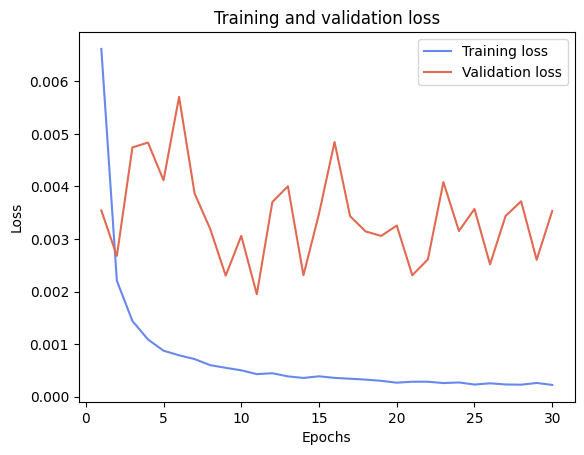

In [142]:
history_visualization(rnn_model_4_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [143]:
print_metrics(rnn_model_4, X_test, y_test)

28/28 [==============================] - 0s 2ms/step
Mean squared error from neural network:  0.0034762695159580967
Mean absolute error from neural network:  0.052907397742657125
R2 score from neural network:  0.9453722920634872


Визуализируем предсказание модели и сравним с реальными данными.

28/28 [==============================] - 0s 3ms/step


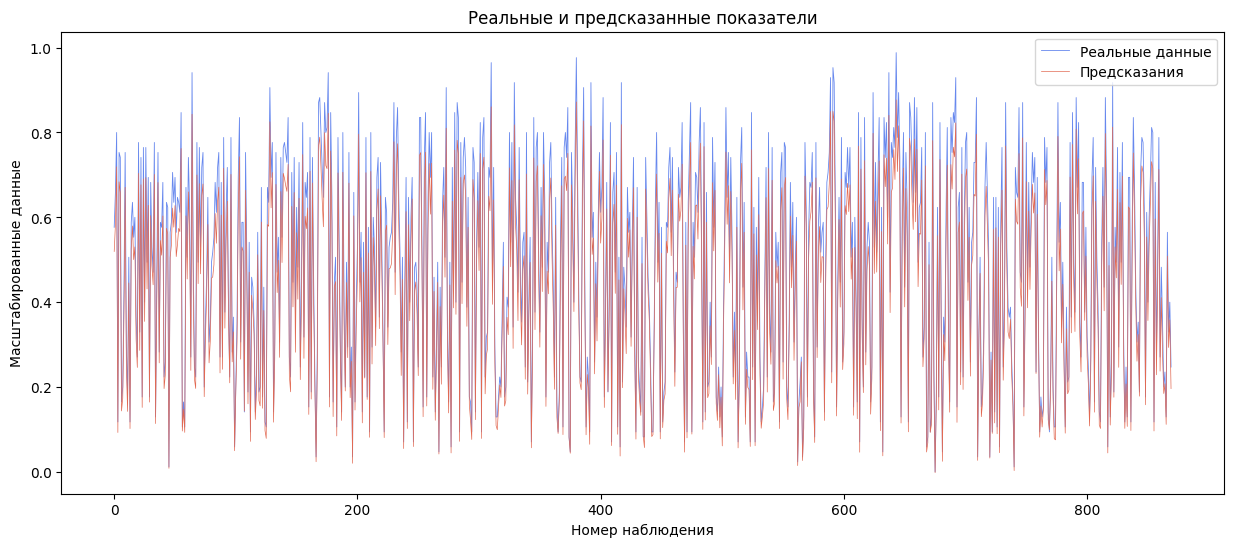

In [144]:
plot_predictions(rnn_model_4, X_test, y_test, colors)

Добавление параметра dropout в данном случае сказалось негативно на качестве модели.

###LSTM

LSTM (Long Short-Term Memory) в Keras представляет собой тип рекуррентной нейронной сети, который используется для обработки последовательностей данных. LSTM способна запоминать и учитывать долгосрочные зависимости в последовательностях данных, что делает ее особенно полезной для работы с текстами, речью, временными рядами и другими типами последовательных данных.

LSTM является одним из типов рекуррентных нейронных сетей и представляет собой улучшенную версию стандартных простых рекуррентных нейронных сетей (RNN). LSTM включает в себя дополнительные блоки памяти, которые помогают сохранять и использовать информацию на протяжении более длительного времени.

####Модель №1

Создаем полносвязную модель рекуррентной нейронной сети с одним скрытым слоем.
Выходной слой возвращает одно число - температуру.

Слой LSTM содержит 32 нейрона, функция активации - relu. Параметр return_sequences означает, следует ли возвращать последний вывод в выходной последовательности или полную последовательность, в данном случае он установлен в False, то есть слой LSTM возвращает только последний вывод. Размеры входного вектора (input_shape) - (количество наблюдений в серии, количество признаков).

Слой Dense содержит 1 нейрон, функция активации - линейная.

В качестве функции потерь используем MSE, используемые метрики - MAE, MSE, R2. Оптимизатор - adam.

Модель будет обучена на 20 эпохах с размером батча равным 32.





In [145]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = 32
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['relu']
lstm_params['is_sequences'] = [False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 20
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [146]:
Params

{'lstm_params': {'units': 32,
  'input_shape': (20, 4),
  'activation': ['relu'],
  'is_sequences': [False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7a20c61a54e0>]},
 'train_params': {'epochs': 20, 'batch_size': 32}}

In [147]:
lstm_model_1 = Sequential()

lstm_model_1.add(
    LSTM(
          Params['lstm_params']['units'],
          input_shape = Params['lstm_params']['input_shape'],
          activation = Params['lstm_params']['activation'][0],
          return_sequences = Params['lstm_params']['is_sequences'][0]
        )
      )

lstm_model_1.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

lstm_model_1.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

lstm_model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4736      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4769 (18.63 KB)
Trainable params: 4769 (18.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [148]:
lstm_model_1_history = lstm_model_1.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/20
127/127 [==============================] - 4s 19ms/step - loss: 0.0654 - mean_absolute_error: 0.1469 - mean_squared_error: 0.0654 - r_square: 0.0025 - val_loss: 0.0022 - val_mean_absolute_error: 0.0371 - val_mean_squared_error: 0.0022 - val_r_square: 0.9662
Epoch 2/20
127/127 [==============================] - 2s 16ms/step - loss: 0.0013 - mean_absolute_error: 0.0288 - mean_squared_error: 0.0013 - r_square: 0.9795 - val_loss: 0.0010 - val_mean_absolute_error: 0.0249 - val_mean_squared_error: 0.0010 - val_r_square: 0.9837
Epoch 3/20
127/127 [==============================] - 2s 14ms/step - loss: 7.7372e-04 - mean_absolute_error: 0.0213 - mean_squared_error: 7.7372e-04 - r_square: 0.9882 - val_loss: 6.9824e-04 - val_mean_absolute_error: 0.0200 - val_mean_squared_error: 6.9824e-04 - val_r_square: 0.9891
Epoch 4/20
127/127 [==============================] - 1s 11ms/step - loss: 6.0229e-04 - mean_absolute_error: 0.0187 - mean_squared_error: 6.0229e-04 - r_square: 0.9908 - val_los

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-73-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-73-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


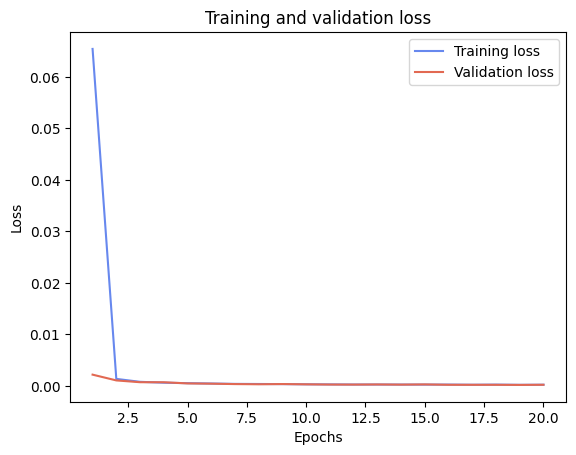

In [149]:
history_visualization(lstm_model_1_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [150]:
print_metrics(lstm_model_1, X_test, y_test)

28/28 [==============================] - 0s 4ms/step
Mean squared error from neural network:  0.0001872084600913887
Mean absolute error from neural network:  0.010445635316312872
R2 score from neural network:  0.9970581196209989


Визуализируем предсказание модели и сравним с реальными данными.

28/28 [==============================] - 0s 4ms/step


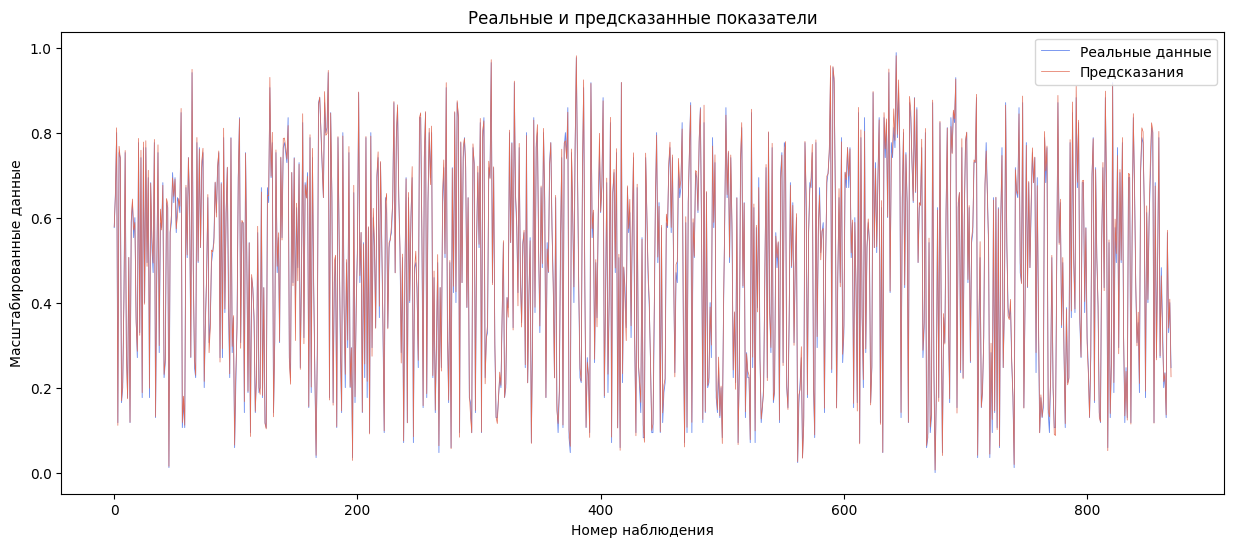

In [151]:
plot_predictions(lstm_model_1, X_test, y_test, colors)

Модель также хорошо справилась с задачей. Обучение шло гладко, на графике предсказанные значения практически совпадают с реальными.

####Модель №2

Увеличим количество эпох до 30 и будем уменьшать коэффициент обучения каждую эпоху, начиная с пятой. Добавим также раннюю остановку.

In [152]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = 32
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['relu']
lstm_params['is_sequences'] = [False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 30
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [153]:
Params

{'lstm_params': {'units': 32,
  'input_shape': (20, 4),
  'activation': ['relu'],
  'is_sequences': [False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7a20ae928040>]},
 'train_params': {'epochs': 30, 'batch_size': 32}}

In [154]:
lstm_model_2 = Sequential()

lstm_model_2.add(
    LSTM(
          Params['lstm_params']['units'],
          input_shape = Params['lstm_params']['input_shape'],
          activation = Params['lstm_params']['activation'][0],
          return_sequences = Params['lstm_params']['is_sequences'][0]
        )
      )

lstm_model_2.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

lstm_model_2.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

lstm_model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4736      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4769 (18.63 KB)
Trainable params: 4769 (18.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [155]:
early_stop = EarlyStopping(
    monitor = 'val_mae',
    patience = 7,
    mode = 'min',
    verbose = 1
  )

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks_list = [
    early_stop,
    lr_cb
  ]

In [156]:
lstm_model_2_history = lstm_model_2.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/30
127/127 [==============================] - 4s 16ms/step - loss: 0.0296 - mean_absolute_error: 0.1080 - mean_squared_error: 0.0296 - r_square: 0.5481 - val_loss: 0.0013 - val_mean_absolute_error: 0.0288 - val_mean_squared_error: 0.0013 - val_r_square: 0.9791
Epoch 2/30
127/127 [==============================] - 2s 15ms/step - loss: 9.1332e-04 - mean_absolute_error: 0.0236 - mean_squared_error: 9.1332e-04 - r_square: 0.9861 - val_loss: 7.0412e-04 - val_mean_absolute_error: 0.0205 - val_mean_squared_error: 7.0412e-04 - val_r_square: 0.9890
Epoch 3/30
127/127 [==============================] - 2s 15ms/step - loss: 6.0674e-04 - mean_absolute_error: 0.0187 - mean_squared_error: 6.0674e-04 - r_square: 0.9907 - val_loss: 4.6468e-04 - val_mean_absolute_error: 0.0161 - val_mean_squared_error: 4.6468e-04 - val_r_square: 0.9928
Epoch 4/30
127/127 [==============================] - 2s 15ms/step - loss: 4.6315e-04 - mean_absolute_error: 0.0162 - mean_squared_error: 4.6315e-04 - r_square: 

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-73-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-73-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


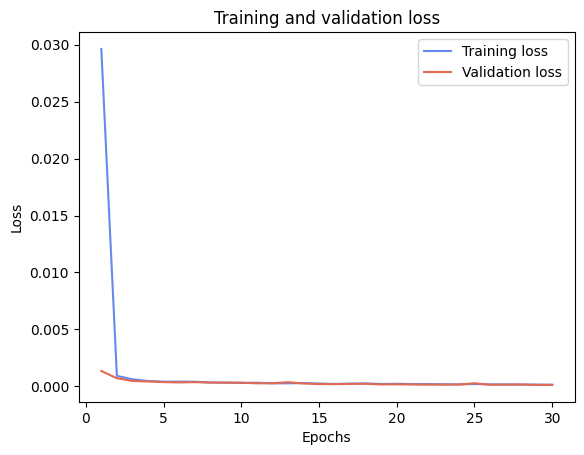

In [157]:
history_visualization(lstm_model_2_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [158]:
print_metrics(lstm_model_2, X_test, y_test)

28/28 [==============================] - 0s 3ms/step
Mean squared error from neural network:  0.00010421094580404777
Mean absolute error from neural network:  0.007500954503401297
R2 score from neural network:  0.9983623809704518


Визуализируем предсказание модели и сравним с реальными данными.

28/28 [==============================] - 0s 3ms/step


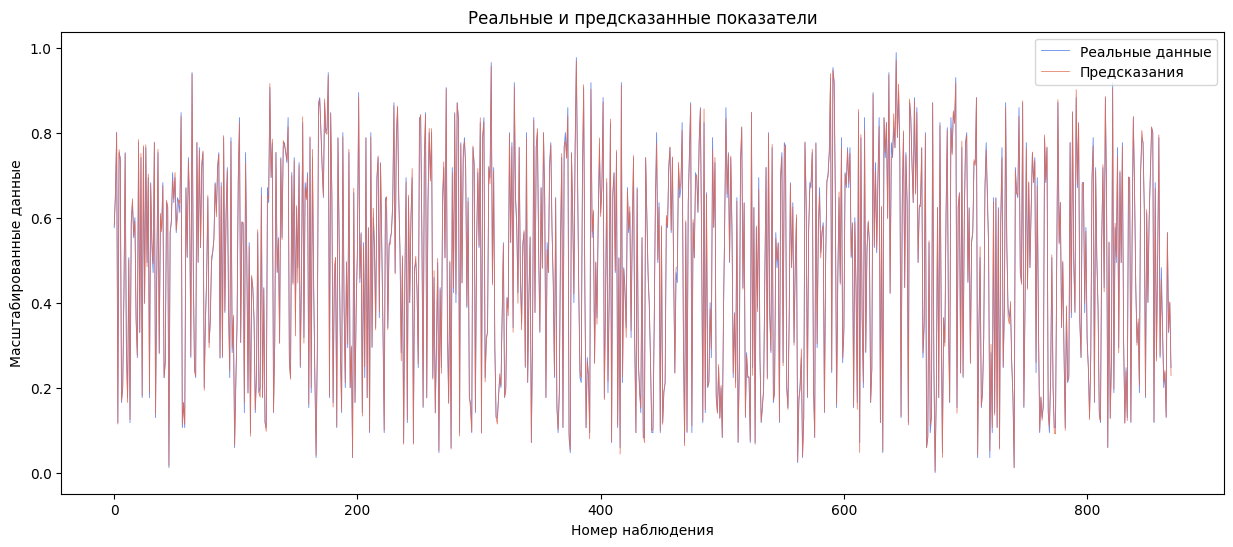

In [159]:
plot_predictions(lstm_model_2, X_test, y_test, colors)

Уменьшение коэффициента скорости обучения не улучшило, не и не ухудшило результаты.

####Модель №3

Оставим callback, уменьшающий скорость обучения на каждой эпохе, но увеличим количество нейронов до 128 в LSTM-слое и добавим dropout с веростностью 0.1. Увеличим количество эпох обучения до 100.

In [160]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = 128
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['relu']
lstm_params['is_sequences'] = [False]
lstm_params['dropout'] = [0.1]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 100
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [161]:
Params

{'lstm_params': {'units': 128,
  'input_shape': (20, 4),
  'activation': ['relu'],
  'is_sequences': [False],
  'dropout': [0.1]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7a20c99277f0>]},
 'train_params': {'epochs': 100, 'batch_size': 32}}

In [162]:
lstm_model_3 = Sequential()

lstm_model_3.add(
    LSTM(
          Params['lstm_params']['units'],
          input_shape = Params['lstm_params']['input_shape'],
          activation = Params['lstm_params']['activation'][0],
          dropout = Params['lstm_params']['dropout'][0],
          return_sequences = Params['lstm_params']['is_sequences'][0]
        )
      )

lstm_model_3.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
      )
    )

lstm_model_3.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

lstm_model_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               68096     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 68225 (266.50 KB)
Trainable params: 68225 (266.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [163]:
early_stop = EarlyStopping(
    monitor = 'val_mae',
    patience = 7,
    mode = 'min',
    verbose = 1
  )

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks_list = [
    early_stop,
    lr_cb
  ]

In [164]:
lstm_model_3_history = lstm_model_3.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/100
127/127 [==============================] - 7s 41ms/step - loss: 0.0192 - mean_absolute_error: 0.0776 - mean_squared_error: 0.0192 - r_square: 0.7077 - val_loss: 0.0035 - val_mean_absolute_error: 0.0499 - val_mean_squared_error: 0.0035 - val_r_square: 0.9450
Epoch 2/100
127/127 [==============================] - 5s 39ms/step - loss: 0.0015 - mean_absolute_error: 0.0295 - mean_squared_error: 0.0015 - r_square: 0.9768 - val_loss: 0.0029 - val_mean_absolute_error: 0.0450 - val_mean_squared_error: 0.0029 - val_r_square: 0.9552
Epoch 3/100
127/127 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_error: 0.0255 - mean_squared_error: 0.0011 - r_square: 0.9829 - val_loss: 0.0044 - val_mean_absolute_error: 0.0565 - val_mean_squared_error: 0.0044 - val_r_square: 0.9312
Epoch 4/100
127/127 [==============================] - 4s 30ms/step - loss: 9.0742e-04 - mean_absolute_error: 0.0227 - mean_squared_error: 9.0742e-04 - r_square: 0.9862 - val_loss: 0.0044 - 

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-73-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-73-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


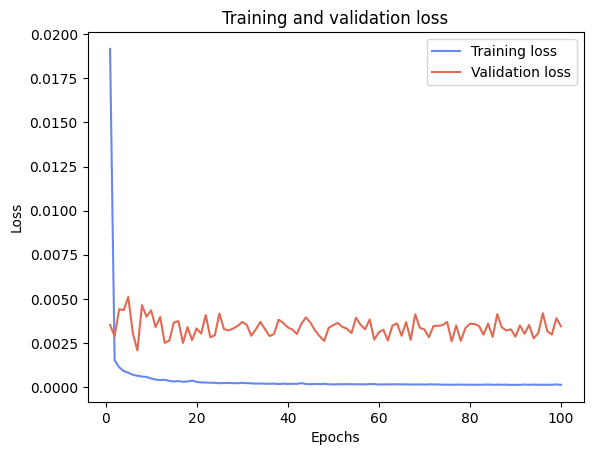

In [165]:
history_visualization(lstm_model_3_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [166]:
print_metrics(lstm_model_3, X_test, y_test)

28/28 [==============================] - 0s 8ms/step
Mean squared error from neural network:  0.0033245019405739604
Mean absolute error from neural network:  0.051290012957242365
R2 score from neural network:  0.9477572379787156


Визуализируем предсказание модели и сравним с реальными данными.

28/28 [==============================] - 0s 9ms/step


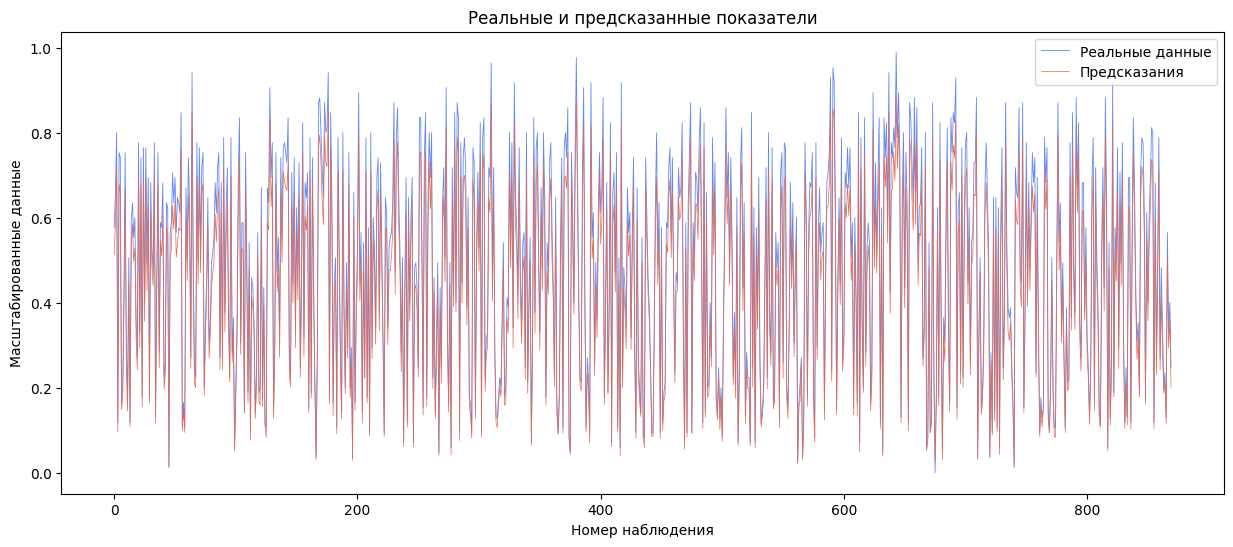

In [167]:
plot_predictions(lstm_model_3, X_test, y_test, colors)

Как видим, выбранные параметры архитектуры и обучения негативно сказались на качестве модели.

###Стек LSTM

Stacked LSTM (стековые LSTM) - это модель рекуррентной нейронной сети, которая состоит из нескольких LSTM-слоев, где каждый слой получает на вход выходной сигнал предыдущего слоя.

####Модель №1

Нейронная сеть содержит два LSTM-слоя. Первый слой содержит 64 нейрона, второй LSTM-слой содержит 32 нейрона, функции активации обоих слоев - relu. Размеры входного вектора (input_shape) - (количество наблюдений в серии, количество признаков).
Параметр return_sequences первого слоя установлен в True, то есть этот LSTM-слой будет получать на вход последовательности, и передавать последовательности на следующий слой. Во втором слое данный параметр установлен в False.

Слой Dense содержит 1 нейрон, функция активации - линейная.

В качестве функции потерь используем MSE, используемые метрики - MAE, MSE, R2. Оптимизатор - adam.

Модель будет обучена на 20 эпохах с размером батча, равным 32.





In [168]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = [64, 32]
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['relu', 'relu']
lstm_params['is_sequences'] = [True, False]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 20
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [169]:
Params

{'lstm_params': {'units': [64, 32],
  'input_shape': (20, 4),
  'activation': ['relu', 'relu'],
  'is_sequences': [True, False]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7a20b810b430>]},
 'train_params': {'epochs': 20, 'batch_size': 32}}

In [170]:
stack_lstm_model_1 = Sequential()

stack_lstm_model_1.add(
    LSTM(
        Params['lstm_params']['units'][0],
        input_shape = Params['lstm_params']['input_shape'],
        activation = Params['lstm_params']['activation'][0],
        return_sequences = Params['lstm_params']['is_sequences'][0]
      )
    )


stack_lstm_model_1.add(
    LSTM(
        Params['lstm_params']['units'][1],
        activation = Params['lstm_params']['activation'][1],
        return_sequences = Params['lstm_params']['is_sequences'][1]
      )
    )

stack_lstm_model_1.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
        )
    )

stack_lstm_model_1.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

stack_lstm_model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 64)            17664     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [171]:
stack_lstm_model_1_history = stack_lstm_model_1.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/20
127/127 [==============================] - 8s 36ms/step - loss: 0.0242 - mean_absolute_error: 0.0879 - mean_squared_error: 0.0242 - r_square: 0.6305 - val_loss: 0.0018 - val_mean_absolute_error: 0.0325 - val_mean_squared_error: 0.0018 - val_r_square: 0.9726
Epoch 2/20
127/127 [==============================] - 4s 32ms/step - loss: 0.0015 - mean_absolute_error: 0.0300 - mean_squared_error: 0.0015 - r_square: 0.9772 - val_loss: 0.0012 - val_mean_absolute_error: 0.0261 - val_mean_squared_error: 0.0012 - val_r_square: 0.9818
Epoch 3/20
127/127 [==============================] - 4s 34ms/step - loss: 0.0010 - mean_absolute_error: 0.0245 - mean_squared_error: 0.0010 - r_square: 0.9841 - val_loss: 8.8640e-04 - val_mean_absolute_error: 0.0226 - val_mean_squared_error: 8.8640e-04 - val_r_square: 0.9862
Epoch 4/20
127/127 [==============================] - 4s 28ms/step - loss: 8.4622e-04 - mean_absolute_error: 0.0221 - mean_squared_error: 8.4622e-04 - r_square: 0.9871 - val_loss: 0.001

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-73-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-73-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


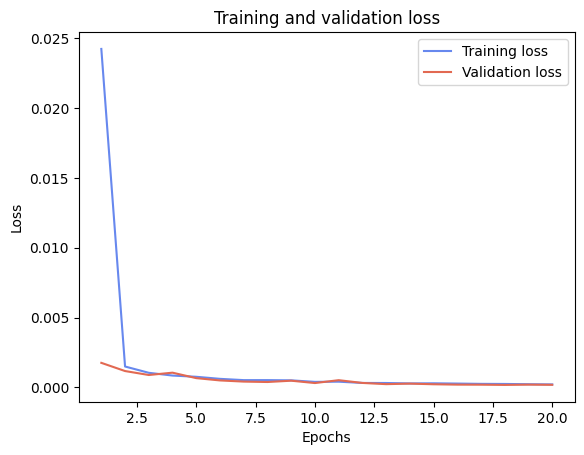

In [172]:
history_visualization(stack_lstm_model_1_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [173]:
print_metrics(stack_lstm_model_1, X_test, y_test)

28/28 [==============================] - 0s 6ms/step
Mean squared error from neural network:  0.000182435837592725
Mean absolute error from neural network:  0.010170370518148664
R2 score from neural network:  0.9971331188196374


Визуализируем предсказание модели и сравним с реальными данными.

28/28 [==============================] - 0s 6ms/step


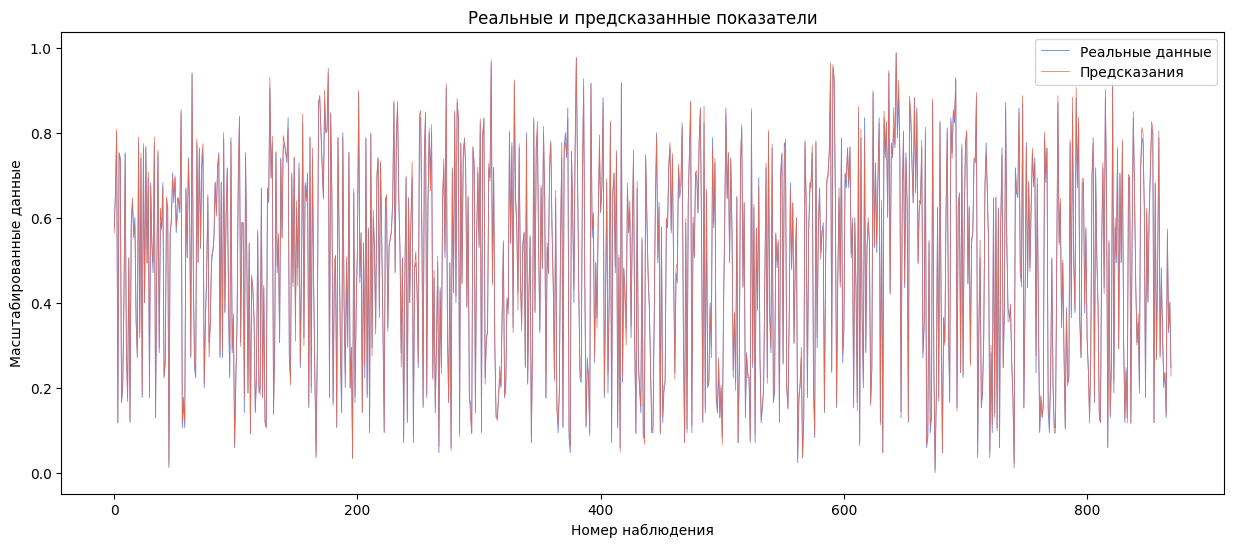

In [174]:
plot_predictions(stack_lstm_model_1, X_test, y_test, colors)

Как видим из графиков, обучение модели проходило гладко и модель обладает высоким качеством прогноза.

####Модель №2

Функцией активации в LSTM по умолчанию является гиперболический тангенс. Восстановим значения по умолчанию.

In [175]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = [64, 32]
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['tanh', 'tanh']
lstm_params['is_sequences'] = [True, False]
lstm_params['dropout'] = [0.00, 0.00]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 20
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [176]:
Params

{'lstm_params': {'units': [64, 32],
  'input_shape': (20, 4),
  'activation': ['tanh', 'tanh'],
  'is_sequences': [True, False],
  'dropout': [0.0, 0.0]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7a20ac8b1db0>]},
 'train_params': {'epochs': 20, 'batch_size': 32}}

In [177]:
stack_lstm_model_2 = Sequential()

stack_lstm_model_2.add(
    LSTM(
        Params['lstm_params']['units'][0],
        input_shape = Params['lstm_params']['input_shape'],
        activation = Params['lstm_params']['activation'][0],
        dropout = Params['lstm_params']['dropout'][0],
        return_sequences = Params['lstm_params']['is_sequences'][0]
      )
    )


stack_lstm_model_2.add(
    LSTM(
        Params['lstm_params']['units'][1],
        activation = Params['lstm_params']['activation'][1],
        dropout = Params['lstm_params']['dropout'][1],
        return_sequences = Params['lstm_params']['is_sequences'][1]
      )
    )

stack_lstm_model_2.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
        )
    )

stack_lstm_model_2.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

stack_lstm_model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 64)            17664     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [178]:
stack_lstm_model_2_history = stack_lstm_model_2.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/20
127/127 [==============================] - 10s 34ms/step - loss: 0.0140 - mean_absolute_error: 0.0650 - mean_squared_error: 0.0140 - r_square: 0.7872 - val_loss: 0.0014 - val_mean_absolute_error: 0.0293 - val_mean_squared_error: 0.0014 - val_r_square: 0.9776
Epoch 2/20
127/127 [==============================] - 3s 23ms/step - loss: 0.0011 - mean_absolute_error: 0.0254 - mean_squared_error: 0.0011 - r_square: 0.9829 - val_loss: 0.0010 - val_mean_absolute_error: 0.0245 - val_mean_squared_error: 0.0010 - val_r_square: 0.9838
Epoch 3/20
127/127 [==============================] - 3s 22ms/step - loss: 9.4226e-04 - mean_absolute_error: 0.0231 - mean_squared_error: 9.4226e-04 - r_square: 0.9856 - val_loss: 8.2991e-04 - val_mean_absolute_error: 0.0217 - val_mean_squared_error: 8.2991e-04 - val_r_square: 0.9871
Epoch 4/20
127/127 [==============================] - 3s 25ms/step - loss: 7.7500e-04 - mean_absolute_error: 0.0210 - mean_squared_error: 7.7500e-04 - r_square: 0.9882 - val_lo

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-73-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-73-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


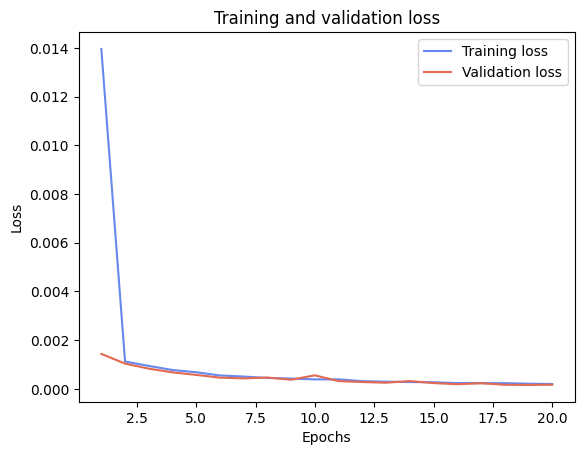

In [179]:
history_visualization(stack_lstm_model_2_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [180]:
print_metrics(stack_lstm_model_2, X_test, y_test)

28/28 [==============================] - 1s 9ms/step
Mean squared error from neural network:  0.00016408957051841733
Mean absolute error from neural network:  0.009564254722313006
R2 score from neural network:  0.9974214205508063


Визуализируем предсказание модели и сравним с реальными данными.

28/28 [==============================] - 0s 9ms/step


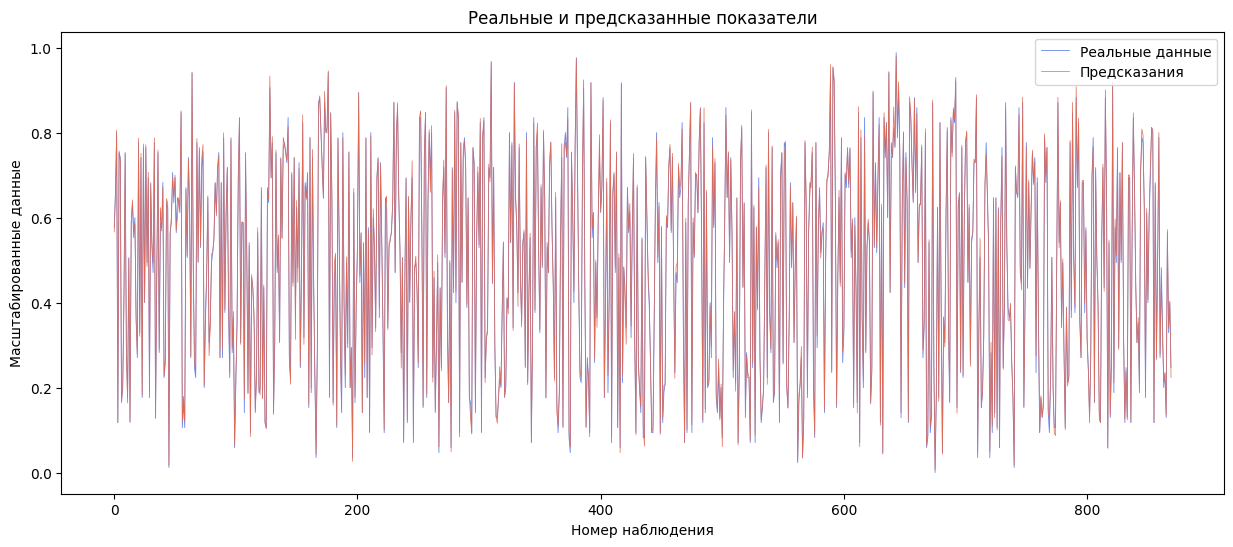

In [181]:
plot_predictions(stack_lstm_model_2, X_test, y_test, colors)

Модель также обладает высокими характеристиками точности прогноза.

####Модель №3

Снова возьмем в качестве функции активации внутренних LSTM-слоёв relu. Добавим dropout. Установим соответствующий параметр в LSTM-слоях в 0.01 и 0.03.

In [182]:
Params = dict()

lstm_params = dict()
dense_params = dict()
compile_params = dict()
train_params = dict()

lstm_params['units'] = [64, 32]
lstm_params['input_shape'] = (series_size,features_num)
lstm_params['activation'] = ['relu', 'relu']
lstm_params['is_sequences'] = [True, False]
lstm_params['dropout'] = [0.01, 0.03]

dense_params['units'] = 1
dense_params['activation'] = ['linear']

compile_params['loss'] = 'mean_squared_error'
compile_params['optimizer'] = 'adam'
compile_params['metrics'] = [
              'mean_absolute_error',
              'mean_squared_error',
              RSquare()
            ]

train_params['epochs'] = 20
train_params['batch_size'] = 32



Params['lstm_params'] = lstm_params
Params['dense_params'] = dense_params
Params['compile_params'] = compile_params
Params['train_params'] = train_params

In [183]:
Params

{'lstm_params': {'units': [64, 32],
  'input_shape': (20, 4),
  'activation': ['relu', 'relu'],
  'is_sequences': [True, False],
  'dropout': [0.01, 0.03]},
 'dense_params': {'units': 1, 'activation': ['linear']},
 'compile_params': {'loss': 'mean_squared_error',
  'optimizer': 'adam',
  'metrics': ['mean_absolute_error',
   'mean_squared_error',
   <tensorflow_addons.metrics.r_square.RSquare at 0x7a20b87a6380>]},
 'train_params': {'epochs': 20, 'batch_size': 32}}

In [184]:
stack_lstm_model_3 = Sequential()

stack_lstm_model_3.add(
    LSTM(
        Params['lstm_params']['units'][0],
        input_shape = Params['lstm_params']['input_shape'],
        activation = Params['lstm_params']['activation'][0],
        dropout = Params['lstm_params']['dropout'][0],
        return_sequences = Params['lstm_params']['is_sequences'][0]
      )
    )


stack_lstm_model_3.add(
    LSTM(
        Params['lstm_params']['units'][1],
        activation = Params['lstm_params']['activation'][1],
        dropout = Params['lstm_params']['dropout'][1],
        return_sequences = Params['lstm_params']['is_sequences'][1]
      )
    )

stack_lstm_model_3.add(
    Dense(
        units = Params['dense_params']['units'],
        activation = Params['dense_params']['activation'][0]
        )
    )

stack_lstm_model_3.compile(
    loss = Params['compile_params']['loss'],
    optimizer = Params['compile_params']['optimizer'],
    metrics = Params['compile_params']['metrics']
  )

stack_lstm_model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 64)            17664     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30113 (117.63 KB)
Trainable params: 30113 (117.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#####Обучение модели

In [185]:
stack_lstm_model_3_history = stack_lstm_model_3.fit(
    X_train,
    y_train,
    validation_data = (X_val,y_val),
    epochs = Params['train_params']['epochs'],
    batch_size = Params['train_params']['batch_size'],
    verbose = 1
  )

Epoch 1/20
127/127 [==============================] - 7s 27ms/step - loss: 0.0267 - mean_absolute_error: 0.0963 - mean_squared_error: 0.0267 - r_square: 0.5926 - val_loss: 0.0019 - val_mean_absolute_error: 0.0340 - val_mean_squared_error: 0.0019 - val_r_square: 0.9702
Epoch 2/20
127/127 [==============================] - 3s 24ms/step - loss: 0.0020 - mean_absolute_error: 0.0343 - mean_squared_error: 0.0020 - r_square: 0.9692 - val_loss: 0.0015 - val_mean_absolute_error: 0.0301 - val_mean_squared_error: 0.0015 - val_r_square: 0.9762
Epoch 3/20
127/127 [==============================] - 5s 37ms/step - loss: 0.0018 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0018 - r_square: 0.9725 - val_loss: 0.0016 - val_mean_absolute_error: 0.0318 - val_mean_squared_error: 0.0016 - val_r_square: 0.9746
Epoch 4/20
127/127 [==============================] - 4s 33ms/step - loss: 0.0014 - mean_absolute_error: 0.0290 - mean_squared_error: 0.0014 - r_square: 0.9781 - val_loss: 0.0010 - val_mean_abs

#####Визуализация процесса обучения

После построим предсказания и визуализируем их. Построим график для визуализации
изменения оценки модели на разных эпохах.

<ipython-input-73-b0a0bfc8f622>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color = colors[0])
<ipython-input-73-b0a0bfc8f622>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'r', label='Validation loss', color = colors[len(colors) - 1])


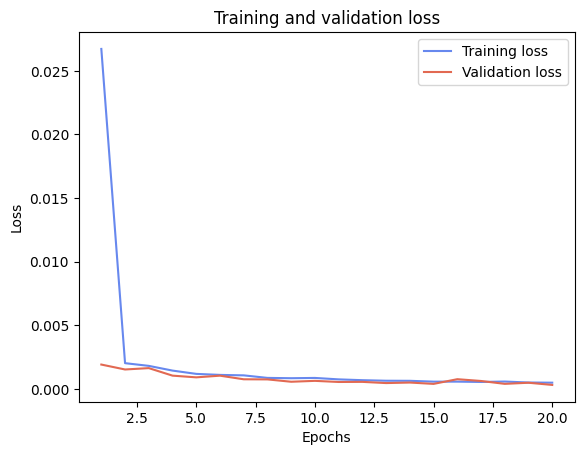

In [186]:
history_visualization(stack_lstm_model_3_history, colors)

Выполним вывод различных метрик оценки качества модели.

In [187]:
print_metrics(stack_lstm_model_3, X_test, y_test)

28/28 [==============================] - 0s 5ms/step
Mean squared error from neural network:  0.00031592584067463163
Mean absolute error from neural network:  0.013058130803333503
R2 score from neural network:  0.9950353951341386


Визуализируем предсказание модели и сравним с реальными данными.

28/28 [==============================] - 0s 6ms/step


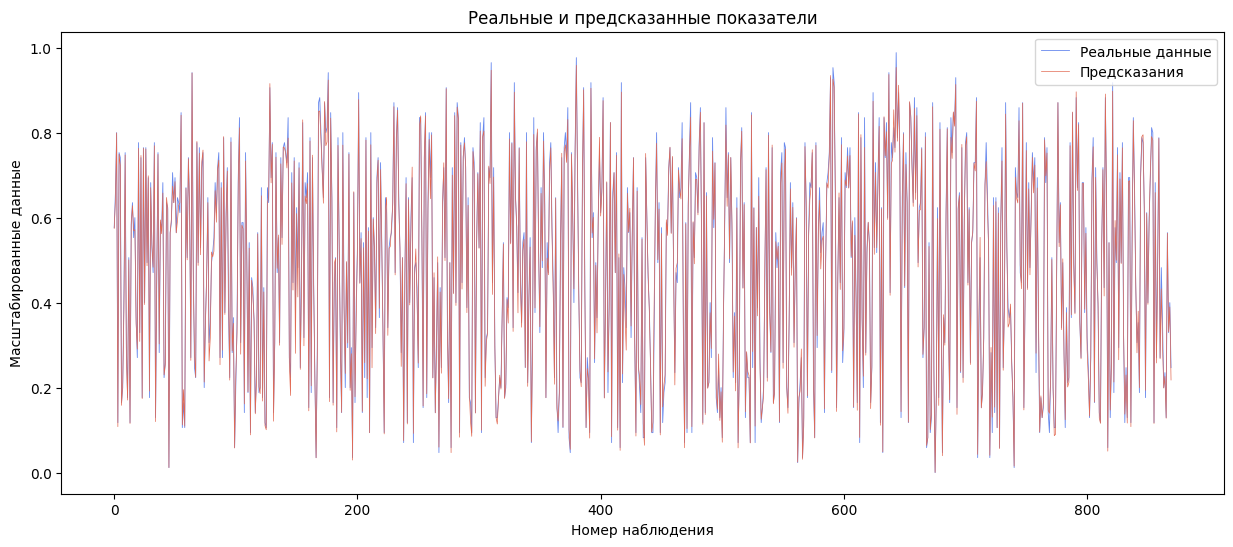

In [188]:
plot_predictions(stack_lstm_model_3, X_test, y_test, colors)

Модель также обладает высокими характеристиками точности прогноза.

##Выводы

Построим график, отображающий значение коэффициента детерминации для каждой модели.

In [189]:
if 'scores_df' in globals():
  scores_df = scores_df[0:0]

scores_df = pd.DataFrame(columns=['architecture', 'model_number', 'R2'])

print(scores_df)

Empty DataFrame
Columns: [architecture, model_number, R2]
Index: []


In [190]:
scores_df.loc[ len(scores_df.index )] = ['SimpleRNN', 1, float("{0:.4f}".format(r2_score(y_test, rnn_model_1.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['SimpleRNN', 2, float("{0:.4f}".format(r2_score(y_test, rnn_model_2.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['SimpleRNN', 3, float("{0:.4f}".format(r2_score(y_test, rnn_model_3.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['SimpleRNN', 4, float("{0:.4f}".format(r2_score(y_test, rnn_model_4.predict(X_test))))]

scores_df.loc[ len(scores_df.index )] = ['LSTM', 1, float("{0:.4f}".format(r2_score(y_test, lstm_model_1.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['LSTM', 2, float("{0:.4f}".format(r2_score(y_test, lstm_model_2.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['LSTM', 3, float("{0:.4f}".format(r2_score(y_test, lstm_model_3.predict(X_test))))]

scores_df.loc[ len(scores_df.index )] = ['StackedLSTM', 1, float("{0:.4f}".format(r2_score(y_test, stack_lstm_model_1.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['StackedLSTM', 2, float("{0:.4f}".format(r2_score(y_test, stack_lstm_model_2.predict(X_test))))]
scores_df.loc[ len(scores_df.index )] = ['StackedLSTM', 3, float("{0:.4f}".format(r2_score(y_test, stack_lstm_model_3.predict(X_test))))]

print(scores_df)

28/28 [==============================] - 0s 11ms/step
  architecture  model_number      R2
0    SimpleRNN             1  0.9975
1    SimpleRNN             2  0.9985
2    SimpleRNN             3  0.9979
3    SimpleRNN             4  0.9454
4         LSTM             1  0.9971
5         LSTM             2  0.9984
6         LSTM             3  0.9478
7  StackedLSTM             1  0.9971
8  StackedLSTM             2  0.9974
9  StackedLSTM             3  0.9950


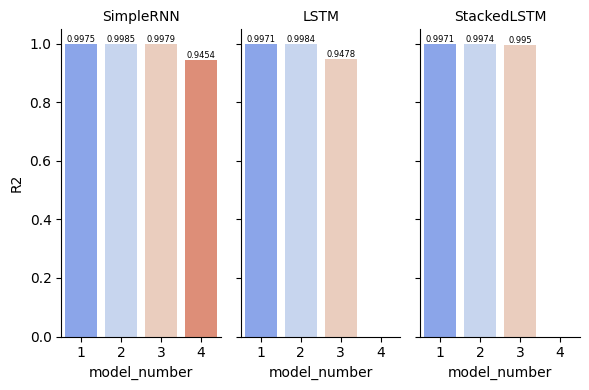

In [191]:
g = sns.catplot(
    scores_df,
    kind="bar",
    x="model_number",
    y="R2",
    col="architecture",
    height=4,
    aspect=.5,
    palette = palette
  )

for i in range(0, 3):
    g.axes[0,i].bar_label(
      g.axes[0,i].containers[0],
      size=6
    )

g.set_titles("{col_name}")

Как видим, все модели достаточно хорошо предсказывают значение температуры в Якутске, однако следует с осторожностью применять dropout, так как он может привести к снижению качества прогноза.